In [1]:
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# qqplot
import statsmodels.api as sm
import pylab as py

from scipy.stats import mannwhitneyu,wilcoxon,spearmanr

In [2]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')

In [3]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font size
plt.rcParams.update({'font.size': 11})
# remove legend edge
plt.rcParams['legend.frameon'] = False

In [4]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# Load data

In [5]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [6]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})

data_choice_level['currNumCities'] = data_choice_level.currNumCities - 1 # starting from 0
data_choice_level['allMAS'] = data_choice_level.allMAS - 1
data_choice_level['currMas'] = data_choice_level.currMas - 1

sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

In [7]:
data_puzzle_level = pd.read_csv(data_dir +  'data.csv') # first column is subject
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])

puzzleID_order_data['mas'] = puzzleID_order_data.mas - 1

# add branching-node RT to puzzle data
index_start = data_choice_level.index[(data_choice_level['branchingFirst'] == True)]
RT_branching = list(data_choice_level.loc[index_start+1, 'RT'])
subjects_chosen = list(data_choice_level.loc[index_start+1, 'subjects'])
puzzle_chosen = list(data_choice_level.loc[index_start+1, 'puzzleID'])

for i in range(len(subjects_chosen)): #
    index_chosen = puzzleID_order_data.index[(puzzleID_order_data['condition']==1)&(puzzleID_order_data['subjects']==subjects_chosen[i])&(puzzleID_order_data['puzzleID']==puzzle_chosen[i])]
    puzzleID_order_data.loc[index_chosen,'RT_branching'] = RT_branching[i]
puzzleID_order_data['RT_branching'] = puzzleID_order_data['RT_branching']/1000

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)


In [8]:
# undo condition
# select the data before the very first undo or submit
data_subset_before1undo_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]     

        for i in range(len(dat_sbj_pzi)):
            if (dat_sbj_pzi.iloc[i]['undo'] != 1)&(dat_sbj_pzi.iloc[i]['submit'] != 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
            elif (dat_sbj_pzi.iloc[i]['undo'] == 1)|(dat_sbj_pzi.iloc[i]['submit'] == 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
                break

data_subset_before1undo = sc_data_choice_level.loc[data_subset_before1undo_index,:]

In [9]:
# undo condition
# select the data before the very first undo only
data_subset_before1undoonly_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]   
        temp_list = []  

        for i in range(len(dat_sbj_pzi)):
            if dat_sbj_pzi.iloc[i]['undo'] != 1:
                temp_list.append(dat_sbj_pzi.index[i])
            elif dat_sbj_pzi.iloc[i]['undo'] == 1:
                data_subset_before1undoonly_index.extend(temp_list)
                break

data_subset_before1undoonly = sc_data_choice_level.loc[data_subset_before1undoonly_index,:]

# Map characteristics - MAS (supp)

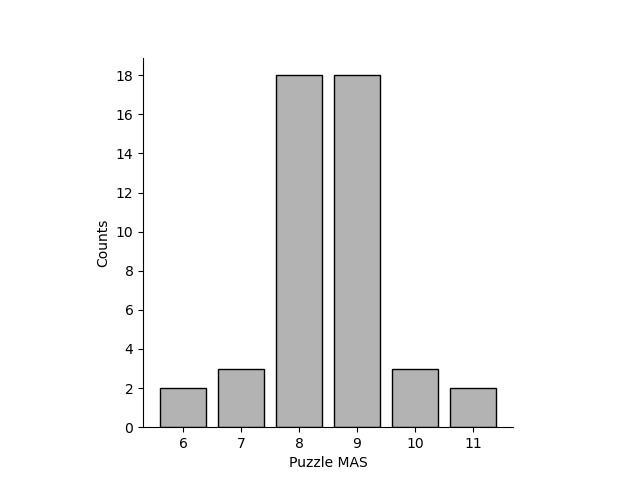

In [10]:
%matplotlib widget

n_mas = single_condition_data[single_condition_data.subjects==2].groupby(['mas'])['mas'].count() # only undo condition

fig, axs = plt.subplots(1, 1)
axs.bar(range(6,12), n_mas,
        color = (.7,.7,.7),
        edgecolor = 'k')## puzzle MAS

### histogram of MAS/remaining budget, numFullUndo',)
axs.set_ylabel('Counts') 
axs.set_yticks(list(range(0, 20, 2)))
axs.set_xlabel('Puzzle MAS')
# change size ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')
#plt.show()
fig.savefig(out_dir + 'count_mas_puzzle.png', dpi=300, bbox_inches='tight')

# Undo Initiation

## Probability of undo - error

### Previous path type

In [57]:
# only first undo
puzzle_error = sc_data_choice_level['allMAS'] - sc_data_choice_level['currMas']
# index before undo/not undo, but the possibility of undo cannot be 0
index_noerror = puzzle_error.index[(puzzle_error == 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo", "allMAS"]]
undo_noerror_avg = undo_noerror.groupby(["subjects"])['undo'].mean()

# index before undo/not undo, but the possibility of undo cannot be 0
index_error = puzzle_error.index[(puzzle_error != 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo", "allMAS"]]
undo_error_avg = undo_error.groupby(["subjects"])['undo'].mean()

print(len(undo_noerror_avg))
print(len(undo_error_avg))

100
100


#### scatter plot

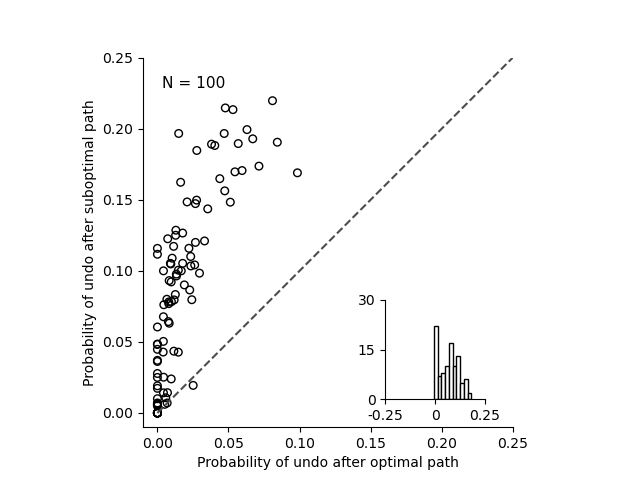

In [58]:
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(undo_noerror_avg), 
            np.array(undo_error_avg), 
            # use white fill
            facecolors = 'none',
            edgecolors='k',
            # size
            s = 30)

axs.set_xlabel('Probability of undo after optimal path')
axs.set_ylabel('Probability of undo after suboptimal path')

axs.set_ylim([-0.01,0.25])
axs.set_xlim([-0.01,0.25])

# add diagonal line
axs.plot([0,0.25], [0,0.25], ls="--", c=".3")

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
        fontsize=11,  va='top')

# make inset ----
axins = inset_axes(plt.gca(), width="27%", height="27%", loc=4, borderpad=2)
axins.hist(np.array(undo_error_avg) - np.array(undo_noerror_avg), 
           bins=10, color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,0.25], 'k--', linewidth=1)
# set x and y lim of axins
axins.set_xlim([0,0.25])
axins.set_ylim([0,0.25])
# set x and y ticks of axins
axins.set_xticks([-0.25,0,0.25])
axins.set_xticklabels(['-0.25','0','0.25'])
axins.set_yticks([0,15,30])

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'undo_path_type.png', dpi=300, bbox_inches='tight')

0.02175728540992308
0.0650974700558826


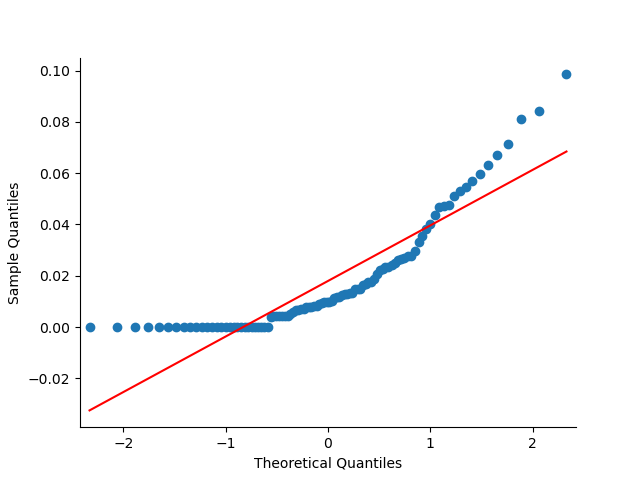

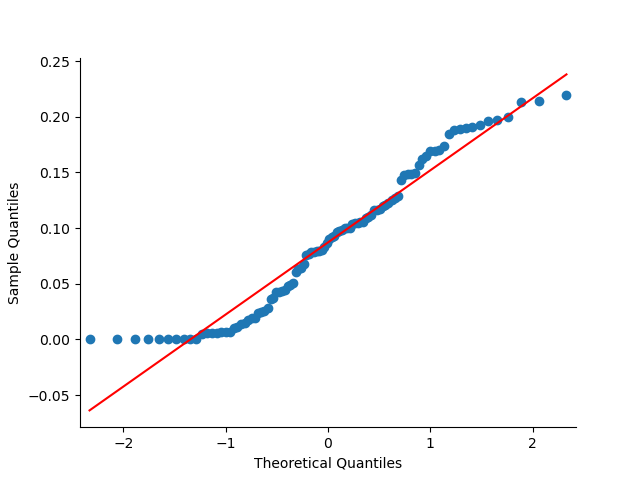

In [59]:
# run 2-independent-sample t test
## check variance
print(np.std(undo_noerror_avg, ddof=1))
print(np.std(undo_error_avg, ddof=1))
## check normality
sm.qqplot(undo_noerror_avg, line='s')
py.show()
sm.qqplot(undo_error_avg, line='s')
py.show()

In [60]:
stat1, p1 = wilcoxon(undo_noerror_avg, undo_error_avg, alternative = 'less')
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 1.1\\times 10^{-16}$')

#### balanced accuracy and correlation

In [61]:
# count number of appearances
# condition negative
print(len(index_noerror))
# condition positive
print(len(index_error))

26862
20368


In [62]:
TNR = 1 - undo_noerror_avg # True Negative Rate 
balanced_accuracy = (undo_error_avg + TNR)/2

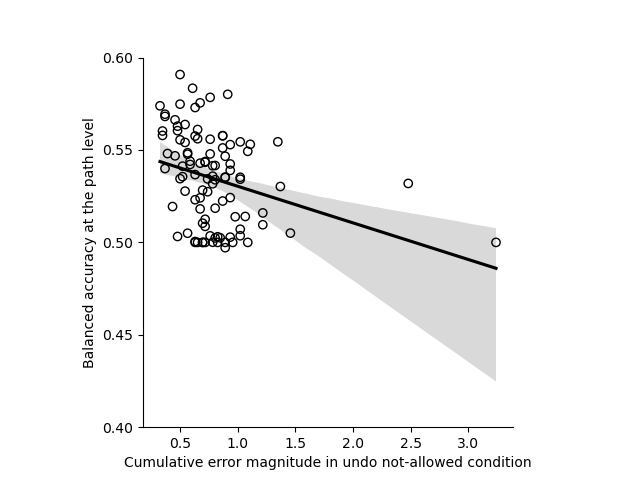

In [19]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy,               
             edgecolor="black",
                facecolor="None")
# add regplot line
sns.regplot(x=score, y=balanced_accuracy, ax=axs, ci=95, scatter=False, color='black')

# set yticks
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy at the path level') #Difference in undo initiation probability \nbetween optimal and suboptimal paths

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'path_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [20]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy)

SpearmanrResult(correlation=-0.38182817993772894, pvalue=8.85945768963304e-05)

### Hit/false alarm across puzzle MAS

In [212]:
undo_noerror_puzzle_avg = undo_noerror.groupby(["subjects", "allMAS"])['undo'].mean().reset_index()
# print(undo_noerror_puzzle_avg.groupby(["allMAS"]).count())

undo_error_puzzle_avg = undo_error.groupby(["subjects", "allMAS"])['undo'].mean().reset_index()
# print(undo_error_puzzle_avg.groupby(["allMAS"]).count())

# caculcate balanced accuracy 
undo_noerror_puzzle_avg['TNR'] = 1 - undo_noerror_puzzle_avg['undo'] # True Negative Rate
# Initialize 'TNR' column with NaN instead of None
undo_error_puzzle_avg['TNR'] = np.nan
# Merge the TNR values from undo_noerror_puzzle_avg to undo_error_puzzle_avg based on 'subjects' and 'allMAS'
undo_error_puzzle_avg = undo_error_puzzle_avg.merge(undo_noerror_puzzle_avg[['subjects', 'allMAS', 'TNR']], on=['subjects', 'allMAS'], how='left', suffixes=('', '_noerror'))
# Fill the 'TNR' column in undo_error_puzzle_avg with the values from undo_noerror_puzzle_avg where they match
undo_error_puzzle_avg['TNR'] = undo_error_puzzle_avg['TNR'].fillna(undo_error_puzzle_avg['TNR_noerror'])
# Drop the extra TNR column
undo_error_puzzle_avg.drop(columns=['TNR_noerror'], inplace=True)
# Calculate balanced accuracy
undo_error_puzzle_avg['balanced_accuracy'] = (undo_error_puzzle_avg['undo'] + undo_error_puzzle_avg['TNR']) / 2

# Print or return the result
print(undo_error_puzzle_avg)

     subjects  allMAS      undo       TNR  balanced_accuracy
0           0       7  0.000000  0.923077           0.461538
1           0       8  0.089286  1.000000           0.544643
2           0       9  0.065574  0.990196           0.527885
3           0      11  0.000000  1.000000           0.500000
4           1       7  0.200000  1.000000           0.600000
..        ...     ...       ...       ...                ...
548        99       7  0.185185  1.000000           0.592593
549        99       8  0.114583  0.990385           0.552484
550        99       9  0.064935  1.000000           0.532468
551        99      10  0.000000  1.000000           0.500000
552        99      11  0.000000  1.000000           0.500000

[553 rows x 5 columns]


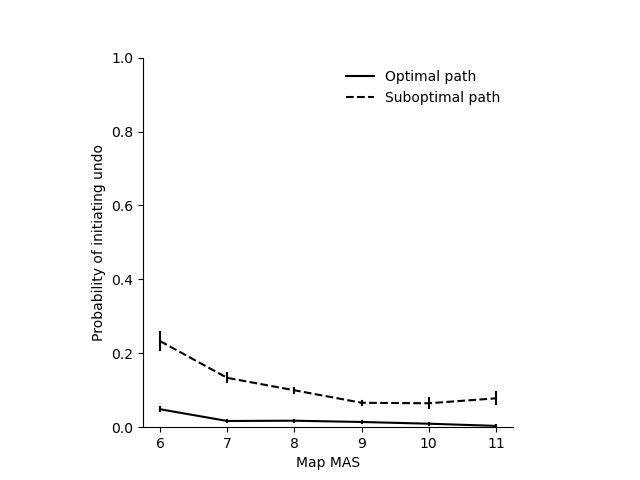

In [216]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='undo', 
             data = undo_noerror_puzzle_avg,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='allMAS', y='undo',
                data = undo_error_puzzle_avg,
                color = 'k',
                err_style = "bars",
                errorbar = "se",
                linestyle = "--")
# sns.lineplot(x='allMAS', y='balanced_accuracy',
#                 data = undo_error_puzzle_avg,
#                 color = 'k',
#                 err_style = "bars",
#                 errorbar = "se",
#                 linestyle = "-.")
# add legend
axs.legend(['Optimal path', 'Suboptimal path'], frameon=False)

axs.set_ylim(0,1)
axs.set(xlabel='Map MAS', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'hit_falsealarm_mas.png', dpi=300, bbox_inches='tight')
plt.show()

### Previous move type

In [49]:
# only first undo
# index before undo/not undo, but the possibility of undo cannot be 0
index_noerror = sc_data_choice_level.index[(sc_data_choice_level['severityOfErrors'] == 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo"]]
move_undo_noerror_avg = undo_noerror.groupby(["subjects"])['undo'].mean()

# index before undo/not undo, but the possibility of undo cannot be 0
index_error = sc_data_choice_level.index[(sc_data_choice_level['severityOfErrors'] != 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo"]]
move_undo_error_avg = undo_error.groupby(["subjects"])['undo'].mean()

print(len(move_undo_noerror_avg))
print(len(move_undo_error_avg))

100
100


#### scatter plot

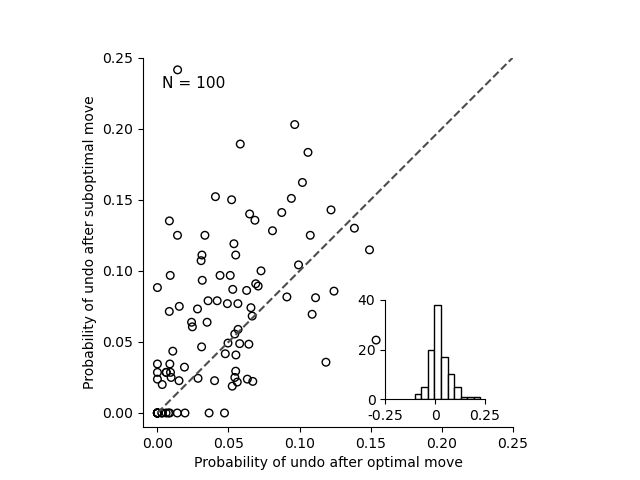

In [51]:
%matplotlib widget

# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(move_undo_noerror_avg), 
            np.array(move_undo_error_avg), 
            # use white fill
            facecolors = 'none',
            edgecolors='k',
            # size
            s = 30)

axs.set_xlabel('Probability of undo after optimal move')
axs.set_ylabel('Probability of undo after suboptimal move')

axs.set_ylim([-0.01,0.25])
axs.set_xlim([-0.01,0.25])

# add diagonal line
axs.plot([0,0.25], [0,0.25], ls="--", c=".3")

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
        fontsize=11,  va='top')

# make inset ----
axins = inset_axes(plt.gca(), width="27%", height="27%", loc=4, borderpad=2)
axins.hist(np.array(move_undo_error_avg) - np.array(move_undo_noerror_avg), 
           bins=10, color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,0.25], 'k--', linewidth=1)
# set x and y lim of axins
axins.set_xlim([0,0.25])
axins.set_ylim([0,0.25])
# set x and y ticks of axins
axins.set_xticks([-0.25,0,0.25])
axins.set_xticklabels(['-0.25','0','0.25'])
axins.set_yticks([0,20,40])

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'undo_move_type', dpi=300, bbox_inches='tight')

0.038925416137539186
0.05806890338994977


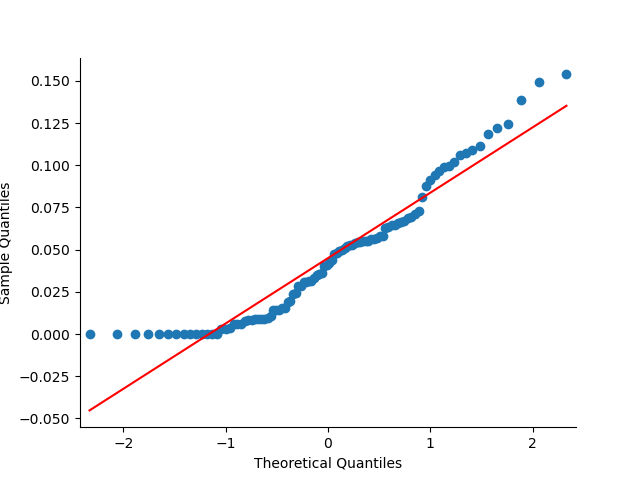

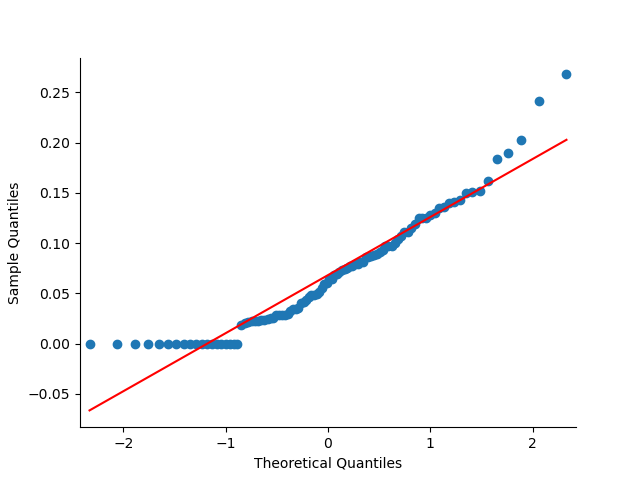

In [52]:
# run 2-independent-sample t test
## check variance
print(np.std(move_undo_noerror_avg, ddof=1))
print(np.std(move_undo_error_avg, ddof=1))
## check normality
sm.qqplot(move_undo_noerror_avg, line='s')
py.show()
sm.qqplot(move_undo_error_avg, line='s')
py.show()

In [53]:
stat1, p1 = wilcoxon(move_undo_noerror_avg, move_undo_error_avg, alternative = 'less')
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 1.1\\times 10^{-5}$')

#### balanced accuracy and correlation (supp)

In [35]:
# count number of appearances
# condition negative
print(len(index_noerror))
# condition positive
print(len(index_error))

42780
4450


In [55]:
move_TNR = 1 - move_undo_noerror_avg # True Negative Rate 
balanced_accuracy_move = (move_undo_error_avg + move_TNR)/2

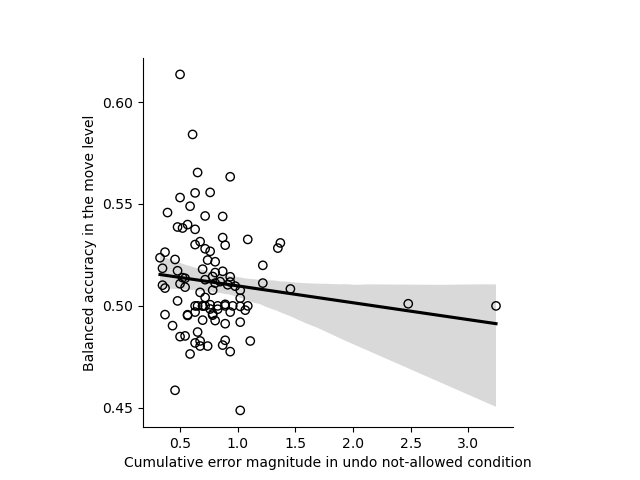

In [56]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy_move,               
             edgecolor="black",
                facecolor="None")
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

# add regplot line
sns.regplot(x=score, y=balanced_accuracy_move, ax=axs, ci=95, scatter=False, color='black')

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy in the move level') # Difference in undo initiation probability \nbetween optimal and suboptimal moves

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'move_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [38]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy_move)

SpearmanrResult(correlation=-0.13378809589916837, pvalue=0.18449713269822837)

### Two balanced accuracy comparison

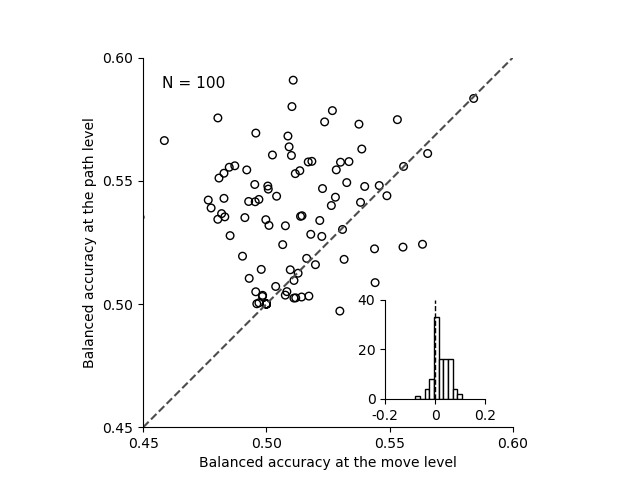

In [39]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(balanced_accuracy_move), 
            np.array(balanced_accuracy), 
            # use white fill
            facecolors = 'none',
            edgecolors='k',
            # size
            s = 30)

axs.set_xlabel('Balanced accuracy at the move level')
axs.set_ylabel('Balanced accuracy at the path level')

axis_range = [0.45,0.6]
axs.set_ylim(axis_range)
axs.set_xlim(axis_range)

# change number of x and y ticks
axs.set_xticks([0.45,0.5,0.55,0.6])
axs.set_yticks([0.45,0.5,0.55,0.6])

# add diagonal line
axs.plot(axis_range, axis_range, ls="--", c=".3")

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
        fontsize=11,  va='top')

# make inset ----
axins = inset_axes(plt.gca(), width="27%", height="27%", loc="lower right", borderpad=2)
axins.hist(np.array(balanced_accuracy) - np.array(balanced_accuracy_move), 
           bins=10, color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,40], 'k--', linewidth=1)
# set x and y lim of axins
axins.set_xlim([-0.2,0.2])
axins.set_ylim([-0.2,0.2])
# set x and y ticks of axins
axins.set_xticks([-0.2,0,0.2])
axins.set_xticklabels(['-0.2','0','0.2'])
axins.set_yticks([0,20,40])

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'two_balanced_acc.png', dpi=300, bbox_inches='tight')

0.02473571685811436
0.025080358734526454


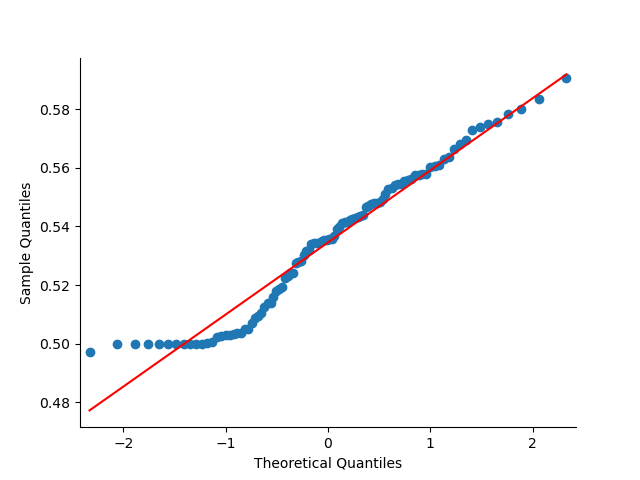

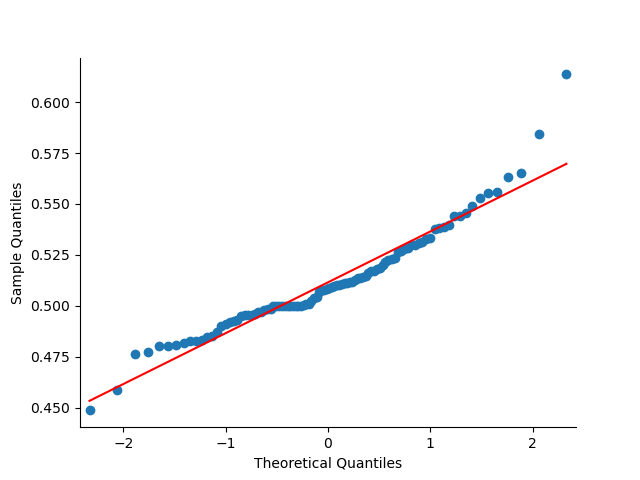

In [40]:
# run 2-independent-sample t test
## check variance
print(np.std(balanced_accuracy, ddof=1))
print(np.std(balanced_accuracy_move, ddof=1))
## check normality
sm.qqplot(balanced_accuracy, line='s')
py.show()
sm.qqplot(balanced_accuracy_move, line='s')
py.show()

In [41]:
stat1, p1 = wilcoxon(balanced_accuracy_move, balanced_accuracy)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 1.3\\times 10^{-9}$')

## Error correction efficiency

### Make errors at the beginning

In [42]:
# remove the steps where the current connected cities is 1. Because the error is calculated as the current state feature. And when at the starting city, there cannot be errors commited.
# basic condition
data_cond0_outcome = data_choice_level[(data_choice_level['condition']==0)&(data_choice_level['currNumCities']!=0)&(data_choice_level['submit']!=1)]
# get the dataframe of the previous state
data_cond0_state = data_choice_level.iloc[data_cond0_outcome.index - 1,:].reset_index(drop=True)
data_cond0_outcome = data_cond0_outcome.reset_index(drop=True)
data_cond0_outcome['prevNumCities'] = data_cond0_state['currNumCities']

In [43]:
data_cond1_outcome = data_subset_before1undo[(data_subset_before1undo['currNumCities']!=0)&(data_subset_before1undo['submit']!=1)]
# get the dataframe of the previous state
data_cond1_state = sc_data_choice_level.iloc[data_cond1_outcome.index - 1,:].reset_index(drop=True)
data_cond1_outcome = data_cond1_outcome.reset_index(drop=True)
data_cond1_outcome['prevNumCities'] = data_cond1_state['currNumCities']

In [44]:
data_cond1_undo_outcome = data_subset_before1undoonly[(data_subset_before1undoonly['currNumCities']!=0)&(data_subset_before1undoonly['submit']!=1)]
# get the dataframe of the previous state
data_cond1_undo_state = sc_data_choice_level.iloc[data_cond1_undo_outcome.index - 1,:].reset_index(drop=True)
data_cond1_undo_outcome = data_cond1_undo_outcome.reset_index(drop=True)
data_cond1_undo_outcome['prevNumCities'] = data_cond1_undo_state['currNumCities']

#### Basic condition (supp)

In [45]:
error_sub = data_cond0_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()
# count number of subjects in each prevNumCities and allMAS
error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:].groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

,prevNumCities,allMAS,error
0,0,8,100
1,0,9,100
2,1,8,100
3,1,9,100
4,2,8,100
5,2,9,100
6,3,8,100
7,3,9,100
8,4,8,100
9,4,9,100


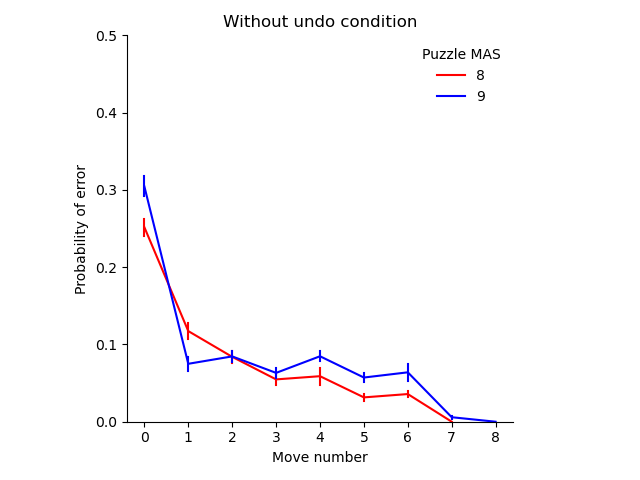

In [47]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', hue = "allMAS", 
             data = error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("Without undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_basic_condition.png', dpi=300, bbox_inches='tight')

In [27]:
%%R -i data_cond0_outcome,out_dir2
data_cond0_outcome$subjects <- as.factor(data_cond0_outcome[,"subjects"])
data_cond0_outcome$allMAS <- as.factor(data_cond0_outcome[,"allMAS"])

model_error = lme4::glmer(error ~  1 + prevNumCities + allMAS + (1 |subjects),
                                  data = data_cond0_outcome[(data_cond0_outcome$allMAS==8)|(data_cond0_outcome$allMAS==9),], family = "binomial")

save(model_error, data_cond0_outcome, file=file.path(out_dir2, file=paste("model_error_step_basic_condition.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: 
data_cond0_outcome[(data_cond0_outcome$allMAS == 8) | (data_cond0_outcome$allMAS ==  
    9), ]

     AIC      BIC   logLik deviance df.resid 
 14572.4  14605.3  -7282.2  14564.4    27387 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0427 -0.3540 -0.2325 -0.1478  8.7125 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1166   0.3415  
Number of obs: 27391, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.42462    0.05214  -27.32  < 2e-16 ***
prevNumCities -0.40420    0.01198  -33.73  < 2e-16 ***
allMAS9        0.16285    0.04450    3.66 0.000252 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
prevNumCits -

#### Undo condition

In [61]:
error_sub = data_cond1_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()
# count number of subjects in each prevNumCities and allMAS
error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:].groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

,prevNumCities,allMAS,error
0,0,8,100
1,0,9,100
2,1,8,100
3,1,9,100
4,2,8,100
5,2,9,100
6,3,8,100
7,3,9,100
8,4,8,100
9,4,9,100


In [62]:
puzzleCount = data_cond1_outcome.loc[(data_cond1_outcome.allMAS==9)&(data_cond1_outcome.prevNumCities==4),:].groupby(['puzzleID'])["error"].mean().reset_index()
print(np.mean(puzzleCount.error))
print(np.std(puzzleCount.error))

0.11001802409003511
0.13734618457502284


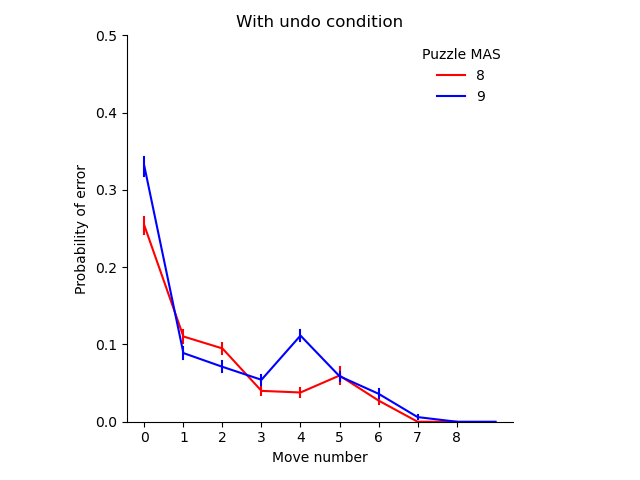

In [63]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', hue = "allMAS", 
             data = error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.set_xticks([0,1,2,3,4,5,6,7,8])
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_undo_condition.png', dpi=300, bbox_inches='tight')

In [34]:
%%R -i data_cond1_outcome,out_dir2
data_cond1_outcome$subjects <- as.factor(data_cond1_outcome[,"subjects"])
data_cond1_outcome$allMAS <- as.factor(data_cond1_outcome[,"allMAS"])

model_error = lme4::glmer(error ~  1 + prevNumCities + allMAS + (1 |subjects),
                                  data = data_cond1_outcome[(data_cond1_outcome$allMAS==8)|(data_cond1_outcome$allMAS==9),], family = "binomial")

save(model_error, data_cond1_outcome, file=file.path(out_dir2, file=paste("model_error_step_undo_condition.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: 
data_cond1_outcome[(data_cond1_outcome$allMAS == 8) | (data_cond1_outcome$allMAS ==  
    9), ]

     AIC      BIC   logLik deviance df.resid 
 14505.5  14538.4  -7248.7  14497.5    27594 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0280 -0.3537 -0.2240 -0.1363  9.4356 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.07439  0.2728  
Number of obs: 27598, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.36711    0.04774 -28.637  < 2e-16 ***
prevNumCities -0.43738    0.01208 -36.206  < 2e-16 ***
allMAS9        0.22579    0.04450   5.074  3.9e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
prevNumCits -

#### Given undo (supp)

In [38]:
error_sub = data_cond1_undo_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()
# count number of subjects in each prevNumCities and allMAS
error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:].groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

,prevNumCities,allMAS,error
0,0,8,85
1,0,9,82
2,1,8,84
3,1,9,81
4,2,8,82
5,2,9,77
6,3,8,82
7,3,9,76
8,4,8,79
9,4,9,75


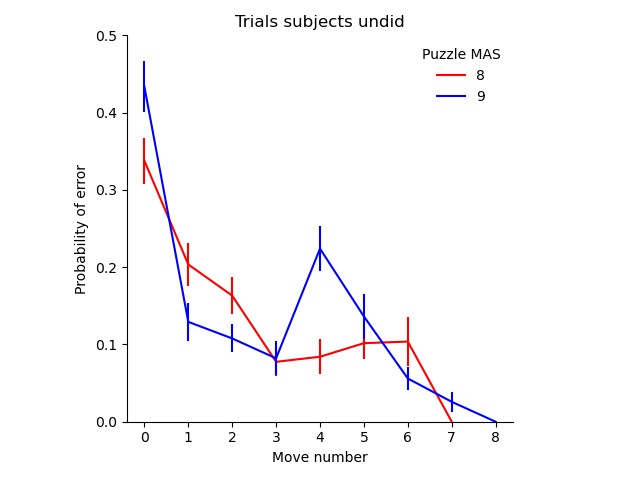

In [39]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', hue = "allMAS", 
             data = error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("Trials subjects undid")
# set x_ticks
axs.set_xticks([0,1,2,3,4,5,6,7,8])
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_given_undo.png', dpi=300, bbox_inches='tight')


In [40]:
%%R -i data_cond1_undo_outcome,out_dir2
data_cond1_undo_outcome$subjects <- as.factor(data_cond1_undo_outcome[,"subjects"])
data_cond1_undo_outcome$allMAS <- as.factor(data_cond1_undo_outcome[,"allMAS"])

model_error = lme4::glmer(error ~  1 + prevNumCities + allMAS + (1 |subjects),
                                  data = data_cond1_undo_outcome[(data_cond1_undo_outcome$allMAS==8)|(data_cond1_undo_outcome$allMAS==9),], family = "binomial")

save(model_error, data_cond1_undo_outcome, file=file.path(out_dir2, file=paste("model_error_step_given_undo.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: data_cond1_undo_outcome[(data_cond1_undo_outcome$allMAS == 8) |  
    (data_cond1_undo_outcome$allMAS == 9), ]

     AIC      BIC   logLik deviance df.resid 
  5200.1   5227.5  -2596.0   5192.1     6910 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7150 -0.4614 -0.3223 -0.2194  5.0797 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.0318   0.1783  
Number of obs: 6914, groups:  subjects, 88

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.04166    0.06631 -15.709  < 2e-16 ***
prevNumCities -0.34095    0.01910 -17.855  < 2e-16 ***
allMAS9        0.20405    0.07212   2.829  0.00466 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
p

### Undo at the end

#### Across step

In [64]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_bf_1undo = data_subset_before1undo.index[(data_subset_before1undo.submit!=1)&(data_subset_before1undo.currNumCities!=0)]

state_df_1undo = data_subset_before1undo.loc[index_bf_1undo, ["subjects", "allMAS", "currNumCities", "checkEnd"]]
state_df_1undo = state_df_1undo.reset_index(drop=True)
state_df_1undo["firstUndo"] = list(sc_data_choice_level.loc[index_bf_1undo+1, "firstUndo"])
state_df_1undo

,subjects,allMAS,currNumCities,checkEnd,firstUndo
0,0,8,1,0,0
1,0,8,2,0,0
2,0,8,3,0,0
3,0,8,4,0,0
4,0,8,5,0,0
...,...,...,...,...,...
35341,99,9,5,0,0
35342,99,9,6,0,0
35343,99,9,7,0,0
35344,99,9,8,0,0


In [65]:
firstUndo_sub = state_df_1undo.groupby(['subjects','currNumCities',"allMAS"])['firstUndo'].mean().reset_index()
firstUndo_sub.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:].groupby(['currNumCities',"allMAS"])['firstUndo'].count().reset_index()

,currNumCities,allMAS,firstUndo
0,1,8,100
1,1,9,100
2,2,8,100
3,2,9,100
4,3,8,100
5,3,9,100
6,4,8,100
7,4,9,100
8,5,8,100
9,5,9,100


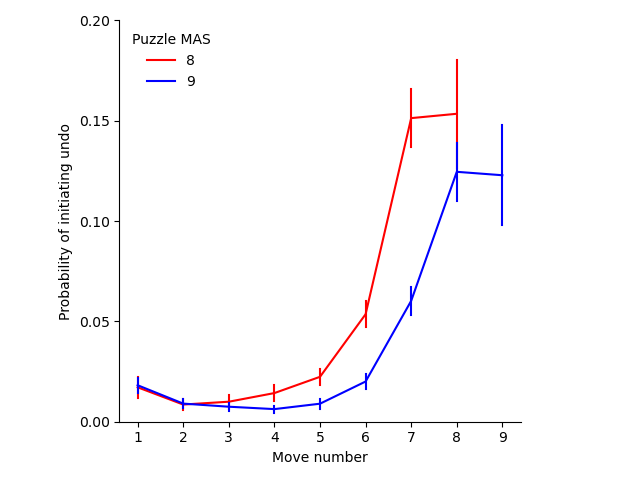

In [66]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', hue = "allMAS", 
             data = firstUndo_sub.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set_yticks(np.linspace(0,0.2,5))
axs.set_ylim([0,0.2])
axs.set(xlabel='Move number', 
        ylabel='Probability of initiating undo')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_step.png', dpi=300, bbox_inches='tight')

In [46]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])
state_df_1undo$allMAS <- as.factor(state_df_1undo[,"allMAS"])

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + allMAS + (1 |subjects),
                                  data = state_df_1undo[(state_df_1undo$allMAS==8)|(state_df_1undo$allMAS==9),], family = "binomial")

save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_step.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + allMAS + (1 | subjects)
   Data: 
state_df_1undo[(state_df_1undo$allMAS == 8) | (state_df_1undo$allMAS ==  
    9), ]

     AIC      BIC   logLik deviance df.resid 
  7514.7   7547.6  -3753.4   7506.7    27594 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.182 -0.206 -0.114 -0.064 34.408 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.197    1.094   
Number of obs: 27598, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -6.18878    0.16720  -37.02   <2e-16 ***
currNumCities  0.52217    0.01857   28.12   <2e-16 ***
allMAS9       -0.67766    0.06716  -10.09   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) crrNmC
currNumCits -0.670       
allMA

#### Terminal or not

In [67]:
state_df_1undo_sub = state_df_1undo[(state_df_1undo.allMAS==8)|(state_df_1undo.allMAS==9)]
undo_end_sub = state_df_1undo_sub[state_df_1undo_sub.checkEnd==1].groupby(['subjects'])['firstUndo'].mean()
undo_notend_sub = state_df_1undo_sub[state_df_1undo_sub.checkEnd==0].groupby(['subjects'])['firstUndo'].mean()
print(len(undo_end_sub))
print(len(undo_notend_sub))

100
100


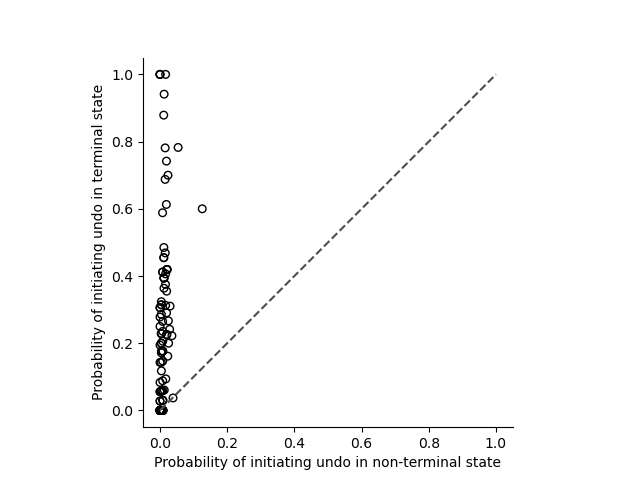

In [69]:
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(undo_notend_sub), 
            np.array(undo_end_sub), 
            facecolors = 'none',  # use white fill
            edgecolors='k',
            s = 30 # size
            )

axs.set_xlabel('Probability of initiating undo in non-terminal state')
axs.set_ylabel('Probability of initiating undo in terminal state')

axs.set_ylim([-0.05,1.05])
axs.set_xlim([-0.05,1.05])

axs.plot([0,1], [0,1], ls="--", c=".3") # add diagonal line
axs.set_aspect(1/axs.get_data_ratio()) # set ratio to be 1:1
plt.show()

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

0.2669240927236181
0.015217854631966633


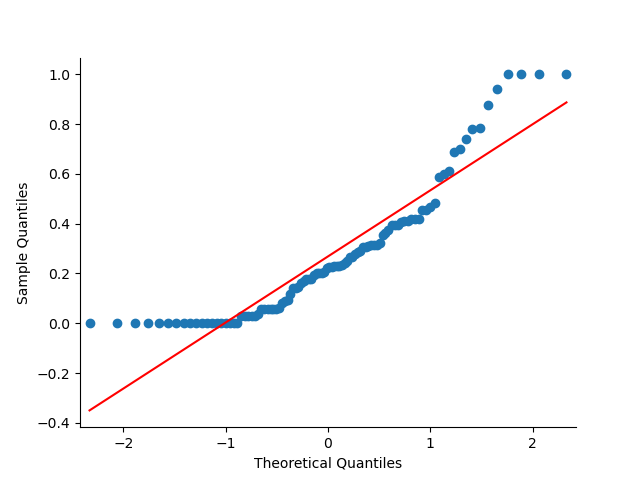

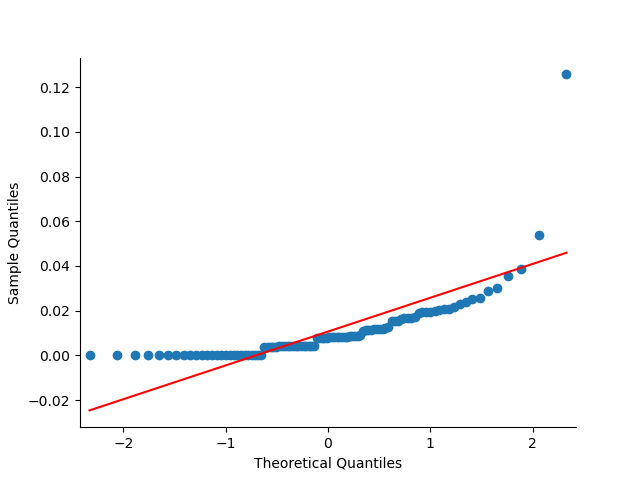

Text(0.5, 1.0, '$p = 4.5\\times 10^{-16}$')

In [70]:
# check equal variance ----
print(np.std(undo_end_sub, ddof=1))
print(np.std(undo_notend_sub, ddof=1))
## violated

# check normality ----
sm.qqplot(undo_end_sub, line='s')
py.show()
sm.qqplot(undo_notend_sub, line='s')
py.show()
## violated

stat1, p1 = mannwhitneyu(np.array(undo_end_sub), np.array(undo_notend_sub)) # should not be paired test! Because of unequal variance, and the measurements are rather unrelated
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

### Sequential undo - terminal

In [71]:
singleundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo == 1)
end_singleundo = data_choice_level.loc[data_choice_level.loc[singleundo,:].index-1, ["checkEnd",'subjects','puzzleID','allMAS']]
end_singleundo = end_singleundo.loc[(end_singleundo.allMAS==8)|(end_singleundo.allMAS==9),:]
end_singleundo['singleUndo'] = 1
end_singleundo['sequentialUndo'] = 0

sequentialundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo != 1)&((data_choice_level.allMAS==8)|(data_choice_level.allMAS==9))
end_sequentialundo = data_choice_level.loc[data_choice_level.loc[sequentialundo,:].index-1,["checkEnd",'subjects','puzzleID','allMAS']]
end_sequentialundo = end_sequentialundo.loc[(end_sequentialundo.allMAS==8)|(end_sequentialundo.allMAS==9),:]
end_sequentialundo['singleUndo'] = 0
end_sequentialundo['sequentialUndo'] = 1

end_undo_df = pd.concat([end_singleundo,end_sequentialundo])

# end_singleundo_avg = end_singleundo.groupby(['subjects'])['checkEnd'].mean()
# end_sequentialundo_avg = end_sequentialundo.groupby(['subjects'])['checkEnd'].mean()

print(sum(end_undo_df.checkEnd==1))
print(sum(end_undo_df.checkEnd==0))
print(sum(end_undo_df.checkEnd==1)+sum(end_undo_df.checkEnd==0))

1506
428
1934


In [72]:
sequentialUndo_sub = end_undo_df.groupby(['subjects','checkEnd'])['sequentialUndo'].mean().reset_index()

n_sub = sequentialUndo_sub.groupby(['checkEnd'])['sequentialUndo'].count().reset_index()
print(n_sub)

   checkEnd  sequentialUndo
0         0              78
1         1              81


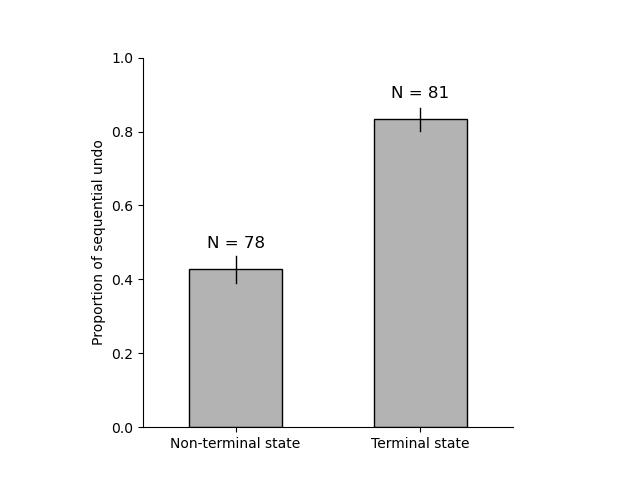

In [73]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.barplot(x='checkEnd', y='sequentialUndo', 
            data = sequentialUndo_sub, 
            color= [0.7,0.7,0.7],
            edgecolor = ['k','k','k'],
            width=.5,
            linewidth=1,
            errcolor = 'k',
            errwidth = 1,
            errorbar = "se")

axs.set_xticklabels(labels = [ "Non-terminal state" , "Terminal state"])#,fontsize=18

# add text on the upper of each bar 
for x, y, n in zip([0,1], sequentialUndo_sub.groupby(['checkEnd'])['sequentialUndo'].mean(), n_sub.sequentialUndo):
    axs.text(x, y+0.05, "N = " + str(n), ha='center', va='bottom', fontsize=12)

axs.set_yticks(np.linspace(0,1,6))
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel = '', ylabel='Proportion of sequential undo')
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig(out_dir+'sequential_terminal.png', dpi=300, bbox_inches='tight')

0.27298251456348316
0.31915638979557404


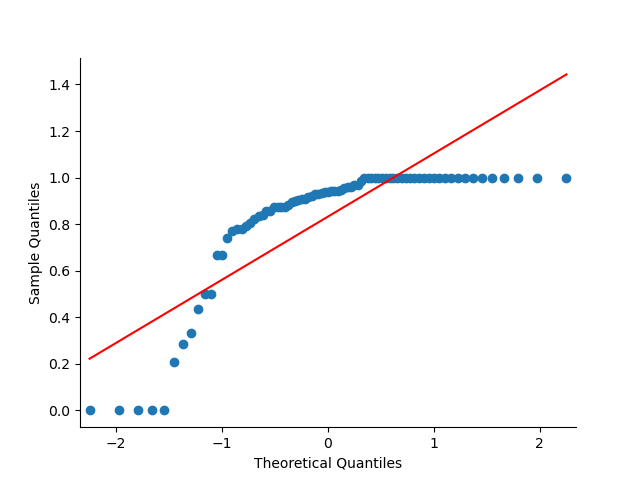

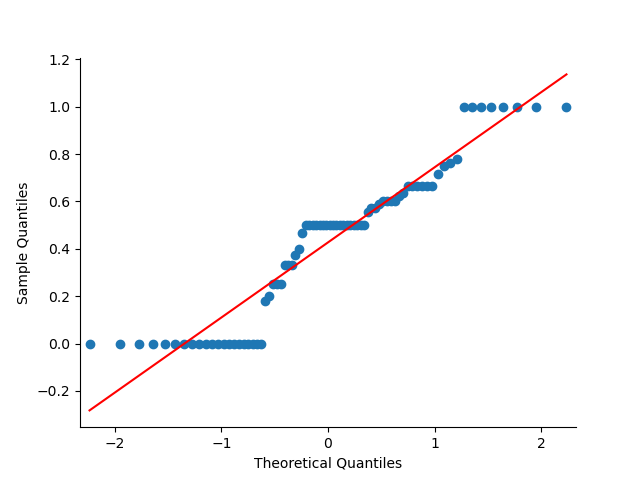

In [57]:
# run 2-independent-sample t test
## check variance
print(np.std(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequentialUndo'], ddof=1))
print(np.std(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequentialUndo'], ddof=1))
## check normality
sm.qqplot(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequentialUndo'], line='s')
py.show()
sm.qqplot(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequentialUndo'], line='s')
py.show()

In [58]:
stat1, p1 = mannwhitneyu(np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequentialUndo']), 
                     np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequentialUndo'])) 
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

5243.0
4.1044025781611534e-13


Text(0.5, 1.0, '$p = 4.1\\times 10^{-13}$')

### Sequential - error magnitude

#### Probability

In [16]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_undo = sc_data_choice_level.index[(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_undo+1, ["subjects","undo",'firstUndo','lastUndo']]
# add sc_data_choice_level.loc[index_undo, "severityOfErrors"] as a list column to undo_error
undo_error['severityOfErrors'] = sc_data_choice_level.loc[index_undo, "severityOfErrors"].values
undo_error['missed_reward'] = sc_data_choice_level.loc[index_undo, "missed_reward"].values
undo_error['error_rate'] = sc_data_choice_level.loc[index_undo, "error_rate"].values
undo_error['sequential_undo'] = (undo_error.firstUndo != undo_error.lastUndo)&(undo_error.firstUndo == 1)
undo_error['single_undo'] = (undo_error.firstUndo == undo_error.lastUndo)&(undo_error.firstUndo == 1)

In [92]:
allUndo_sub = undo_error.groupby(['subjects','severityOfErrors'])['undo'].mean().reset_index()
allUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index()

,severityOfErrors,subjects
0,0,100
1,1,100
2,2,98
3,3,65
4,4,22
5,5,3
6,6,3


In [93]:
singleUndo_sub = undo_error.groupby(['subjects','severityOfErrors'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index()

,severityOfErrors,subjects
0,0,100
1,1,100
2,2,98
3,3,65
4,4,22
5,5,3
6,6,3


In [94]:
sequentialundo_sub = undo_error.groupby(['subjects','severityOfErrors'])['sequential_undo'].mean().reset_index()
sequentialundo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index()

,severityOfErrors,subjects
0,0,100
1,1,100
2,2,98
3,3,65
4,4,22
5,5,3
6,6,3


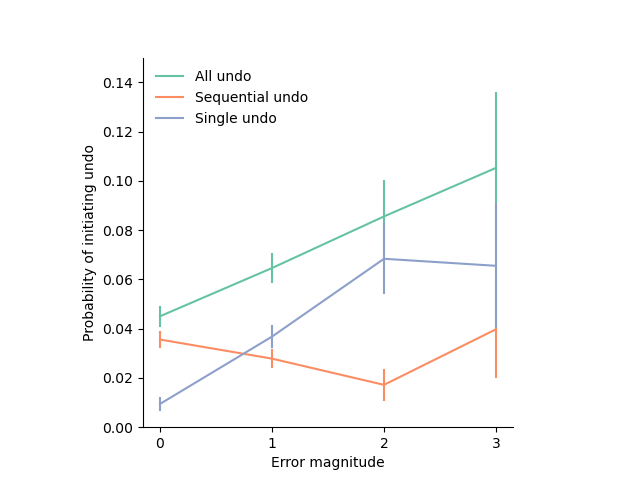

In [78]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='severityOfErrors', y='undo', 
             data = allUndo_sub[allUndo_sub.severityOfErrors<=3], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='sequential_undo',
             data = sequentialundo_sub[sequentialundo_sub.severityOfErrors<=3],
             color = '#fc8d62',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='single_undo',
                data = singleUndo_sub[singleUndo_sub.severityOfErrors<=3],
                color = '#8da0cb',
                err_style = "bars",
                errorbar = "se")

# add manual legend
plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

axs.set_xticks([0,1,2,3])
axs.set_ylim(0,0.15)


axs.set(xlabel='Error magnitude', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'sequential_error_magnitude.png', dpi=300, bbox_inches='tight')

In [64]:
%%R -i undo_error,out_dir2
undo_error$subjects <- as.factor(undo_error[,"subjects"])

model_undo = lme4::glmer(undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_error[(undo_error$severityOfErrors<=3),], family = "binomial")

save(model_undo, undo_error, file=file.path(out_dir2, file=paste("model_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_error[(undo_error$severityOfErrors <= 3), ]

     AIC      BIC   logLik deviance df.resid 
 19227.6  19253.9  -9610.8  19221.6    47181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5989 -0.2826 -0.2286 -0.1184 13.0289 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.41     1.187   
Number of obs: 47184, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.51237    0.12662 -27.739  < 2e-16 ***
severityOfErrors  0.28037    0.04627   6.059 1.37e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.058


In [65]:
%%R -i undo_error,out_dir2
undo_error$subjects <- as.factor(undo_error[,"subjects"])

model_undo = lme4::glmer(sequential_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_error[(undo_error$severityOfErrors<=3),], family = "binomial")

save(model_undo, undo_error, file=file.path(out_dir2, file=paste("model_sequential_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: sequential_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_error[(undo_error$severityOfErrors <= 3), ]

     AIC      BIC   logLik deviance df.resid 
 16031.0  16057.3  -8012.5  16025.0    47181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.3743 -0.2494 -0.2018 -0.0950 14.2864 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.932    1.39    
Number of obs: 47184, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.90865    0.15101 -25.883  < 2e-16 ***
severityOfErrors -0.28306    0.07342  -3.855 0.000116 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.041


In [66]:
%%R -i undo_error,out_dir2
undo_error$subjects <- as.factor(undo_error[,"subjects"])

model_undo = lme4::glmer(single_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_error[(undo_error$severityOfErrors<=3),], family = "binomial")

save(model_undo, undo_error, file=file.path(out_dir2, file=paste("model_single_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: single_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_error[(undo_error$severityOfErrors <= 3), ]

     AIC      BIC   logLik deviance df.resid 
  5363.7   5390.0  -2678.8   5357.7    47181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6426 -0.0988 -0.0794 -0.0570 21.4739 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.199    1.095   
Number of obs: 47184, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.28211    0.13389  -39.45   <2e-16 ***
severityOfErrors  1.03828    0.05983   17.35   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.187


#### Missed reward

In [17]:
allUndo_sub = undo_error.groupby(['subjects','missed_reward'])['undo'].mean().reset_index()
allUndo_sub.groupby(['missed_reward'])['subjects'].count().reset_index()

,missed_reward,subjects
0,0,100
1,22,63
2,26,97
3,30,100
4,34,100
5,38,91
6,40,26
7,42,80
8,48,64
9,54,5


In [18]:
singleUndo_sub = undo_error.groupby(['subjects','missed_reward'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['missed_reward'])['subjects'].count().reset_index()

,missed_reward,subjects
0,0,100
1,22,63
2,26,97
3,30,100
4,34,100
5,38,91
6,40,26
7,42,80
8,48,64
9,54,5


In [19]:
sequentialundo_sub = undo_error.groupby(['subjects','missed_reward'])['sequential_undo'].mean().reset_index()
sequentialundo_sub.groupby(['missed_reward'])['subjects'].count().reset_index()

,missed_reward,subjects
0,0,100
1,22,63
2,26,97
3,30,100
4,34,100
5,38,91
6,40,26
7,42,80
8,48,64
9,54,5


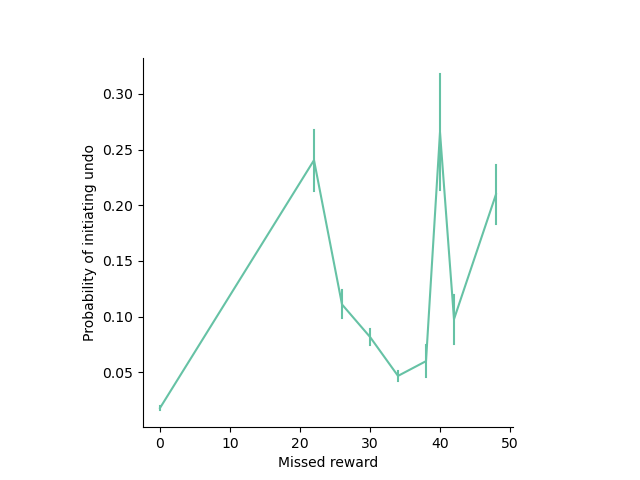

In [24]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='missed_reward', y='undo', 
             data = allUndo_sub[allUndo_sub.missed_reward<=50], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
# sns.lineplot(x='missed_reward', y='sequential_undo',
#              data = sequentialundo_sub,#[sequentialundo_sub.missed_reward<=32],
#              color = '#fc8d62',
#              err_style = "bars",
#              errorbar = "se")
# sns.lineplot(x='missed_reward', y='single_undo',
#                 data = singleUndo_sub,#[singleUndo_sub.missed_reward<=32],
#                 color = '#8da0cb',
#                 err_style = "bars",
#                 errorbar = "se")

# add manual legend
# plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

# axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)


axs.set(xlabel='Missed reward', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'sequential_missed_reward.png', dpi=300, bbox_inches='tight')

#### Error rate

In [25]:
allUndo_sub = undo_error.groupby(['subjects','error_rate'])['undo'].mean().reset_index()
allUndo_sub.groupby(['error_rate'])['subjects'].count().reset_index()

,error_rate,subjects
0,0.000000,100
1,0.090909,71
2,0.100000,93
3,0.111111,99
4,0.125000,100
5,0.142857,100
6,0.166667,100
7,0.200000,100
8,0.222222,46
9,0.250000,100


In [143]:
singleUndo_sub = undo_error.groupby(['subjects','error_rate'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['error_rate'])['subjects'].count().reset_index()

,error_rate,subjects
0,0.000000,100
1,0.090909,5
2,0.100000,22
3,0.111111,24
4,0.125000,79
5,0.142857,94
6,0.166667,99
7,0.200000,98
8,0.250000,98
9,0.285714,14


In [144]:
sequentialundo_sub = undo_error.groupby(['subjects','error_rate'])['sequential_undo'].mean().reset_index()
sequentialundo_sub.groupby(['error_rate'])['subjects'].count().reset_index()

,error_rate,subjects
0,0.000000,100
1,0.090909,5
2,0.100000,22
3,0.111111,24
4,0.125000,79
5,0.142857,94
6,0.166667,99
7,0.200000,98
8,0.250000,98
9,0.285714,14


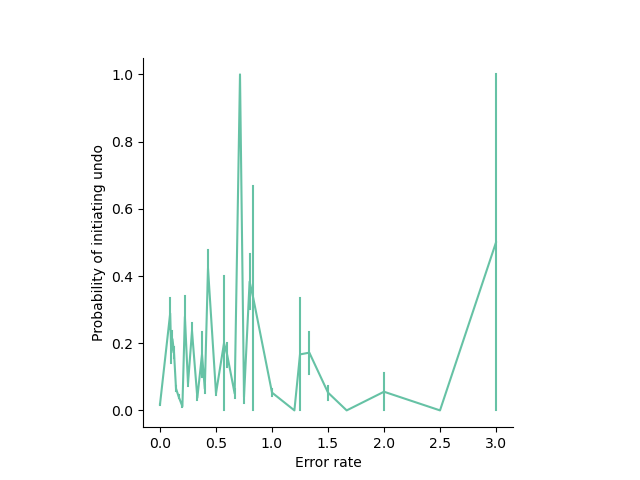

In [26]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='error_rate', y='undo', 
             data = allUndo_sub,#[allUndo_sub.missed_reward<=30], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
# sns.lineplot(x='error_rate', y='sequential_undo',
#              data = sequentialundo_sub,#[sequentialundo_sub.missed_reward<=32],
#              color = '#fc8d62',
#              err_style = "bars",
#              errorbar = "se")
# sns.lineplot(x='error_rate', y='single_undo',
#                 data = singleUndo_sub,#[singleUndo_sub.missed_reward<=32],
#                 color = '#8da0cb',
#                 err_style = "bars",
#                 errorbar = "se")

# add manual legend
# plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

# axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)


axs.set(xlabel='Error rate', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'sequential_error_rate.png', dpi=300, bbox_inches='tight')

#### Proportion

In [67]:
singleundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo == 1)
error_singleundo = data_choice_level.loc[data_choice_level.loc[singleundo,:].index-1, ["severityOfErrors",'subjects','puzzleID']]
error_singleundo['singleUndo'] = 1
error_singleundo['sequentialUndo'] = 0

sequentialundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo != 1)
error_sequentialundo = data_choice_level.loc[data_choice_level.loc[sequentialundo,:].index-1,["severityOfErrors",'subjects','puzzleID']]
error_sequentialundo['singleUndo'] = 0
error_sequentialundo['sequentialUndo'] = 1

error_undo_df = pd.concat([error_singleundo,error_sequentialundo])

In [68]:
singleUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['singleUndo'].mean().reset_index()
singleUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index()

,severityOfErrors,subjects
0,0,86
1,1,76
2,2,33
3,3,14
4,4,1
5,6,1


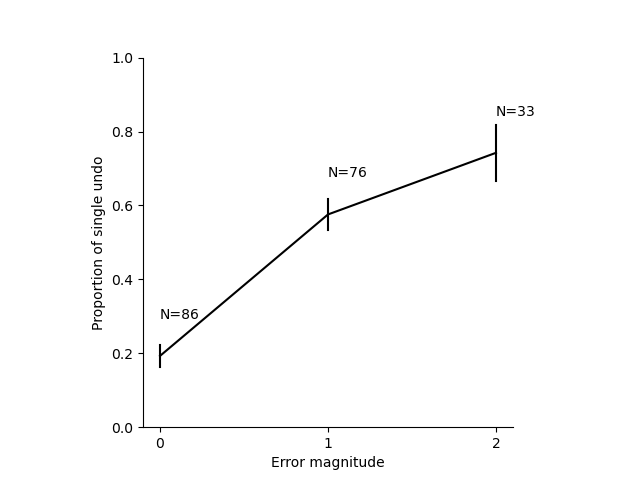

In [69]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
lineplot = sns.lineplot(x='severityOfErrors', y='singleUndo', 
             data = singleUndo_sub[singleUndo_sub.severityOfErrors<=2], 
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([0,1,2])
axs.set_yticks([0,0.2,0.4,0.6,0.8,1])

n_sub = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['subjects'].count().reset_index()
# add each n_sub to each dot on the line,  y uses the position of each dot
# loop through lineplot dots
for i in range(len(n_sub)):
    # add text to lineplot
    lineplot.text(x = n_sub.severityOfErrors[i], # x-coordinate position of data label, padded to be right of the scatterplot
                  y = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['singleUndo'].mean()[i]+0.1, # y-coordinate position of data label, padded to be above scatterplot
                  s = "N="+str(n_sub.subjects[i]), # data label, formatted to ignore decimals
                  color = 'black') # set colour of line


#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Error magnitude', ylabel='Proportion of single undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'prop_single_error_magnitude.png', dpi=300, bbox_inches='tight')

In [110]:
%%R -i error_undo_df,out_dir2
error_undo_df$subjects <- as.factor(error_undo_df[,"subjects"])

# lambda = 0.33
# error_undo_df$severityOfErrors_lamda <- (error_undo_df$severityOfErrors^lambda-1)/lambda

model_undo = lme4::glmer(singleUndo ~  1 + severityOfErrors + (1 |subjects),
                                  data = error_undo_df[(error_undo_df$severityOfErrors<=2),], family = "binomial")

save(model_undo, error_undo_df, file=file.path(out_dir2, file=paste("model_prop_single_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: singleUndo ~ 1 + severityOfErrors + (1 | subjects)
   Data: error_undo_df[(error_undo_df$severityOfErrors <= 2), ]

     AIC      BIC   logLik deviance df.resid 
  2027.0   2044.6  -1010.5   2021.0     2638 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4190 -0.3621 -0.2929 -0.2109  5.3607 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 2.067    1.438   
Number of obs: 2641, groups:  subjects, 90

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.8446     0.1795  -10.28   <2e-16 ***
severityOfErrors   2.0182     0.1373   14.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.205


## Possible cues for error correction

In [12]:
# na can happen in branching_RT because there may be "fake undo"
def filter_dataframe(df, col1_list, col2_list):
    RT1 = []
    RT_branching = []
    for i, j in zip(col1_list, col2_list):
        temp = df[(df['subjects'] == i) & (df['puzzleID'] == j)]
        if not temp.empty:
            RT1.append(float(temp.loc[:,"RT1"].values))
            RT_branching.append(float(temp.loc[:,"RT_branching"].values))
        if temp.empty:
            RT1.append(np.nan)
            RT_branching.append(np.nan)
    return RT1, RT_branching

def filter_dataframe_TT(df, col1_list, col2_list):
    TT = []
    for i, j in zip(col1_list, col2_list):
        temp = df[(df['subjects'] == i) & (df['puzzleID'] == j)]
        if not temp.empty:
            TT.append(float(temp.loc[:,"TT"].values))
        if temp.empty:
            TT.append(np.nan)
    return TT

# before undo
index_first_undo =  sc_data_choice_level.index[sc_data_choice_level['firstUndo'] == 1] 
df_beforeUndo = sc_data_choice_level.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)&(df_beforeUndo.currMas == df_beforeUndo.allMAS)] # there are no errors and  end of trial
state_undo = df_beforeUndo.loc[index_end_undo, ['leftover','currNumCities','subjects','puzzleID']]
state_undo['lastRT'] = sc_data_choice_level.loc[index_end_undo+1, 'RT'].values
state_undo['lastRT_log'] = np.log(sc_data_choice_level.loc[index_end_undo+1, 'RT'].values/1000+1)
state_undo = state_undo.drop_duplicates()

subjects_undo = list(state_undo['subjects'])
puzzleID_undo = list(state_undo['puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects_undo, puzzleID_undo)
TT = filter_dataframe_TT(puzzleID_order_data[puzzleID_order_data['condition']==0].copy(), subjects_undo, puzzleID_undo)
state_undo["RT1"] = RT1
state_undo["RT_branching"] = RT_branching
state_undo["TT"] = TT
state_undo['firstUndo'] = 1

# before submit
index_notundo = sc_data_choice_level.index[(sc_data_choice_level['submit'] == 1)] # submit
df_notbeforeUndo = sc_data_choice_level.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo.checkEnd == 1)&(df_notbeforeUndo.currMas == df_notbeforeUndo.allMAS)]
state_notundo = df_notbeforeUndo.loc[index_end_notundo,['leftover','currNumCities','subjects','puzzleID']]
state_notundo['lastRT'] = sc_data_choice_level.loc[index_end_notundo+1, 'RT'].values
state_notundo['lastRT_log'] = np.log(sc_data_choice_level.loc[index_end_notundo+1, 'RT'].values/1000+1)
state_notundo = state_notundo.drop_duplicates()

subjects = list(state_notundo['subjects'])
puzzleID = list(state_notundo['puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects, puzzleID)
TT = filter_dataframe_TT(puzzleID_order_data[puzzleID_order_data['condition']==0].copy(), subjects, puzzleID)
state_notundo["RT1"] = RT1
state_notundo["RT_branching"] = RT_branching
state_notundo["TT"] = TT
state_notundo['firstUndo'] = 0

state_notundo = state_notundo[~(state_notundo['subjects'].isin(subjects_undo) & state_notundo['puzzleID'].isin(puzzleID_undo))] # only use those which directly submit

state_df = pd.concat([state_undo,state_notundo])
# bin leftover into 5 bins and create a new column
temp1, cutoff = pd.cut(state_df['leftover'], bins=[0,7,14,21,28,35,42], labels=range(1,7),retbins=True)
state_df['leftover_bin'] = temp1
state_df['leftover_bin'] = state_df['leftover_bin'].astype(int)
# get the cutoffs for each bin
state_df = state_df.reset_index(drop=True)
state_df


,leftover,currNumCities,subjects,puzzleID,lastRT,lastRT_log,RT1,RT_branching,TT,firstUndo,leftover_bin
0,8.622047,7,0,19,8789,2.281259,5.159,NaN,40.438,1,2
1,24.281846,9,0,32,4159,1.640743,3.113,NaN,20.711,1,4
2,14.438090,8,2,42,4137,1.636469,12.393,NaN,20.979,1,3
3,20.819878,6,2,1,2084,1.126227,12.950,NaN,22.062,1,3
4,8.621321,8,2,15,3471,1.497612,5.674,NaN,17.801,1,2
...,...,...,...,...,...,...,...,...,...,...,...
1272,21.994079,8,98,38,1021,0.703592,2.211,NaN,19.738,0,4
1273,3.511872,8,98,20,1032,0.709021,2.559,NaN,17.652,0,1
1274,30.247948,9,98,32,886,0.634458,2.388,NaN,19.980,0,5
1275,10.842372,8,98,7,1046,0.715887,5.172,NaN,19.872,0,2


### People undo from optimal state

In [112]:
mas_gain_df = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','mas_gain'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
        # all last undo
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            # get cumulative error at undo beginning
            cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
            cum_error_beginning_list.append(cum_error_beginning)
            error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
            error_beginning_list.append(error_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # use each value in cum_error_beginning_list to subtract accu_severity_error
        mas_gain = []
        for i in range(len(cum_error_beginning_list)):
            mas_gain.append(cum_error_beginning_list[i] - accu_severity_error[i])
        
        
        # if category is not empty, add it to an empty dataframe
        if len(mas_gain) > 0:
            mas_gain_df = pd.concat([mas_gain_df,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                 'mas_gain':mas_gain})])


In [113]:
mas_gain_df_sub = mas_gain_df.groupby(['subjects','cum_error_beginning']).count().reset_index()
mas_gain_df_sub.groupby(['cum_error_beginning'])['subjects'].count().reset_index()

,cum_error_beginning,subjects
0,0,72
1,1,82
2,2,82
3,3,58
4,4,31
5,5,4
6,6,1


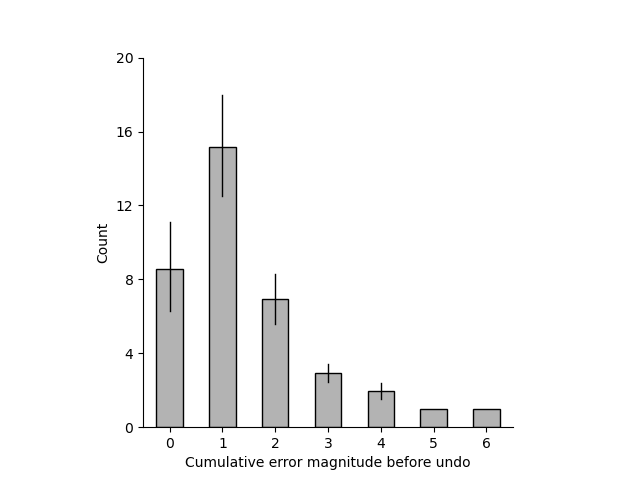

In [114]:
# plot accu_error_sub as sns barplot
%matplotlib widget

fig, axs = plt.subplots(1,1)
sns.barplot(x = 'cum_error_beginning', y = 'puzzleID', data = mas_gain_df_sub, 
            color = [.7,.7,.7],
            width=.5, linewidth=1,
            # error bar parameters
            errwidth = 1,
            errcolor = 'k',
            edgecolor = 'k',
            ax = axs)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Count')
# reset y axis tick
axs.set_yticks(range(0,24,4))

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'count_cumulative_error.png', dpi=300, bbox_inches='tight')


### Achievd score in a puzzle

In [115]:
firstUndo_sub = state_df.groupby(['subjects','currNumCities'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['currNumCities'])['firstUndo'].count()

currNumCities
6     76
7     44
8     81
9     90
10    49
11    46
Name: firstUndo, dtype: int64

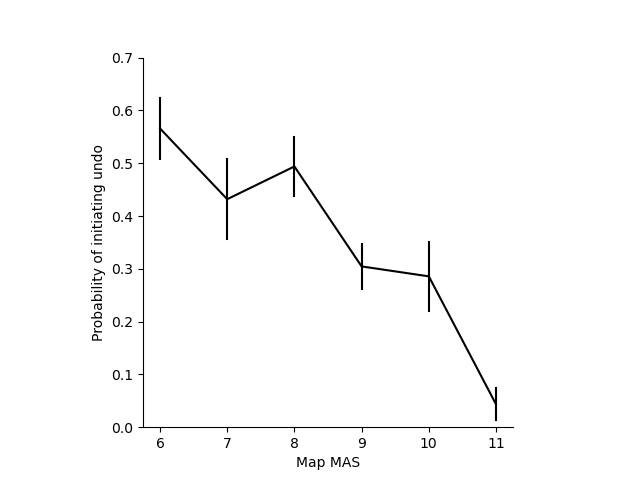

In [116]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', 
             data = firstUndo_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set_ylim(0,0.7)
axs.set(xlabel='Map MAS', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_score_optimal.png', dpi=300, bbox_inches='tight')
plt.show()

#### Check total RT confound (supp)

In [ ]:
TT_sub = state_df.groupby(['subjects','currNumCities'])['TT'].mean().reset_index()
TT_sub.groupby(['currNumCities'])['TT'].count()

currNumCities
6     76
7     44
8     81
9     90
10    49
11    46
Name: TT, dtype: int64

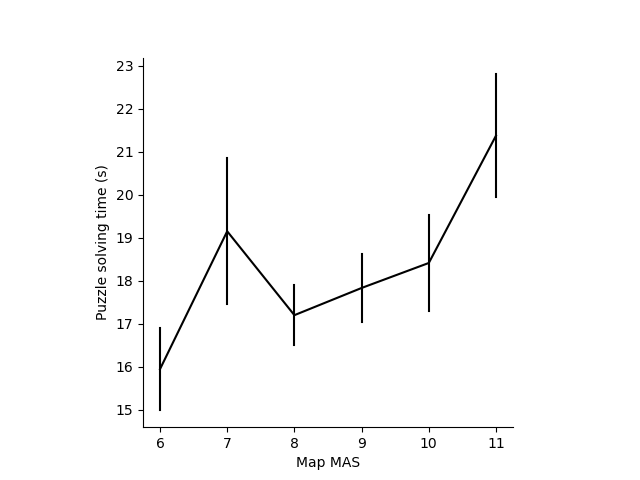

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='TT', data = TT_sub, color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Map MAS', ylabel='Puzzle solving time (s)')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'TT_achieved_score.png', dpi=300, bbox_inches='tight')

In [ ]:
%%R -i state_df,out_dir2
state_df$subjects <- as.factor(state_df[,"subjects"])
state_df$TT_new <- state_df[,"TT"]^(0.5)

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + TT_new + (1 |subjects) ,
                                  data = state_df, family = binomial(link="logit"))

save(model_undo, state_df, file=file.path(out_dir2, file=paste("model_undo_optimal_mas_TT.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + TT_new + (1 | subjects)
   Data: state_df

     AIC      BIC   logLik deviance df.resid 
   460.4    481.0   -226.2    452.4     1273 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.95979 -0.03162 -0.01085  0.04180  2.05925 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 50.72    7.122   
Number of obs: 1277, groups:  subjects, 99

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    13.7913     2.4972   5.523 3.34e-08 ***
currNumCities  -2.0698     0.2856  -7.248 4.23e-13 ***
TT_new          0.1943     0.2376   0.818    0.414    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) crrNmC
currNumCits -0.842       
TT_new      -0.341 -0.049


### Remaining budget

In [168]:
firstUndo_sub = state_df.groupby(['subjects','leftover_bin'])['firstUndo'].mean().reset_index()
# count ignore nan
firstUndo_sub.groupby(['leftover_bin'])['firstUndo'].count()

leftover_bin
1    92
2    80
3    74
4    81
5    34
6    19
Name: firstUndo, dtype: int64

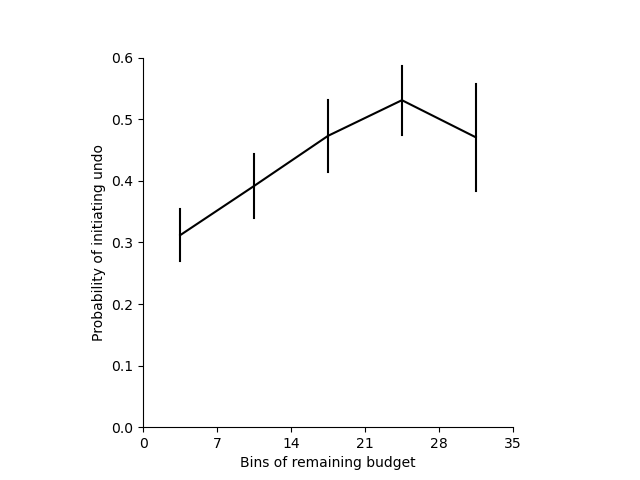

In [169]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.leftover_bin<=5],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 6.5, 1))
axs.set_xticklabels(cutoff[:-1])
axs.set_ylim(0,0.6)
axs.set(xlabel='Bins of remaining budget', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_optimal_budget.png', dpi=300, bbox_inches='tight')
plt.show()

In [152]:
spearmanr(state_df['leftover'], state_df['currNumCities'])

SpearmanrResult(correlation=-0.0778188560543579, pvalue=0.005396443586058339)

In [174]:
%%R -i state_df,out_dir2
state_df$subjects <- as.factor(state_df[,"subjects"])
state_df$TT_new <- state_df[,"TT"]^(0.5)
state_df$leftover_new <- state_df[,"leftover"]^(0.3)

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + leftover_new + TT_new + (1 |subjects) ,
                                  data = state_df, family = binomial(link="logit"))

save(model_undo, state_df, file=file.path(out_dir2, file=paste("model_undo_optimal_mas_TT_budget.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + leftover_new + TT_new + (1 |  
    subjects)
   Data: state_df

     AIC      BIC   logLik deviance df.resid 
   352.5    378.3   -171.3    342.5     1272 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1928 -0.0172 -0.0021  0.0081  4.8372 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 134.6    11.6    
Number of obs: 1277, groups:  subjects, 99

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)     6.3250     3.0795   2.054    0.040 *  
currNumCities  -2.4965     0.4100  -6.088 1.14e-09 ***
leftover_new    5.3295     0.8872   6.007 1.89e-09 ***
TT_new          0.3189     0.3514   0.908    0.364    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) crrNmC lftvr_
currNumCits -0.6

### Only cumulative error == 1

In [13]:
# before undo
index_first_undo =  sc_data_choice_level.index[sc_data_choice_level['firstUndo'] == 1] 
df_beforeUndo = sc_data_choice_level.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)&(df_beforeUndo.currMas == (df_beforeUndo.allMAS-1))] # there are no errors and  end of trial
state_undo = df_beforeUndo.loc[index_end_undo, ['leftover','currNumCities','subjects','puzzleID']]
state_undo = state_undo.drop_duplicates()

subjects_undo = list(state_undo['subjects'])
puzzleID_undo = list(state_undo['puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects_undo, puzzleID_undo)
TT = filter_dataframe_TT(puzzleID_order_data[puzzleID_order_data['condition']==0].copy(), subjects_undo, puzzleID_undo)
state_undo['firstUndo'] = 1

# before submit
index_notundo = sc_data_choice_level.index[(sc_data_choice_level['submit'] == 1)] # submit
df_notbeforeUndo = sc_data_choice_level.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo.checkEnd == 1)&(df_notbeforeUndo.currMas == (df_notbeforeUndo.allMAS-1))]
state_notundo = df_notbeforeUndo.loc[index_end_notundo,['leftover','currNumCities','subjects','puzzleID']]
state_notundo = state_notundo.drop_duplicates()

subjects = list(state_notundo['subjects'])
puzzleID = list(state_notundo['puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects, puzzleID)
TT = filter_dataframe_TT(puzzleID_order_data[puzzleID_order_data['condition']==0].copy(), subjects, puzzleID)
state_notundo['firstUndo'] = 0

state_notundo = state_notundo[~(state_notundo['subjects'].isin(subjects_undo) & state_notundo['puzzleID'].isin(puzzleID_undo))] # only use those which directly submit

state_df = pd.concat([state_undo,state_notundo])
# bin leftover into 5 bins and create a new column
state_df = state_df.reset_index(drop=True)
state_df


,leftover,currNumCities,subjects,puzzleID,firstUndo
0,15.622087,7,0,28,1
1,37.545393,7,0,8,1
2,50.763052,7,0,40,1
3,56.385707,8,0,31,1
4,49.216224,8,0,41,1
...,...,...,...,...,...
1319,23.992798,8,98,14,0
1320,24.302558,8,98,4,0
1321,30.793457,7,98,29,0
1322,33.814995,6,98,17,0


In [14]:
firstUndo_sub = state_df.groupby(['subjects','currNumCities'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['currNumCities'])['firstUndo'].count()

currNumCities
5     46
6     67
7     90
8     86
9     42
10    41
Name: firstUndo, dtype: int64

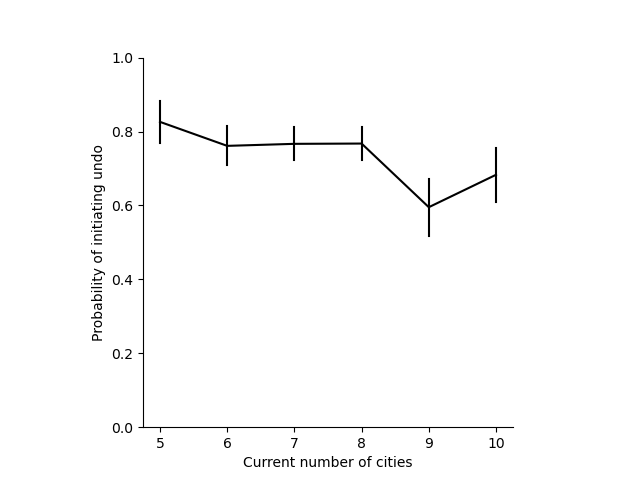

In [15]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', 
             data = firstUndo_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set_ylim(0,1)
axs.set(xlabel='Current number of cities', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_score_optimal.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
%%R -i state_df,out_dir2
state_df$subjects <- as.factor(state_df[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + (1 |subjects) ,
                                  data = state_df, family = binomial(link="logit"))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + (1 | subjects)
   Data: state_df

     AIC      BIC   logLik deviance df.resid 
    76.5     92.1    -35.3     70.5     1321 

Scaled residuals: 
      Min        1Q    Median        3Q       Max 
-0.056274 -0.011715  0.000380  0.000405  0.000470 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 6803     82.48   
Number of obs: 1324, groups:  subjects, 99

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)    16.6506     6.1827   2.693  0.00708 **
currNumCities  -0.1329     0.8311  -0.160  0.87299   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
currNumCits -0.969


### Uncertainty

#### First-move RT

In [20]:
# for RT1 and RT_branching, use only the very first undo
    
# before undo
index_first_undo = data_subset_before1undo.index[(data_subset_before1undo['firstUndo'] == 1)] # submit
df_beforeUndo = data_subset_before1undo.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)&(df_beforeUndo.currMas == df_beforeUndo.allMAS)] # there are no errors and  end of trial
state_undo_1undo = df_beforeUndo.loc[index_end_undo, ['subjects','puzzleID']]

subjects_undo = list(df_beforeUndo.loc[index_end_undo,'subjects'])
puzzleID_undo = list(df_beforeUndo.loc[index_end_undo,'puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects_undo, puzzleID_undo)
RT1_basic,_ = filter_dataframe(puzzleID_order_data[puzzleID_order_data['condition']==0], subjects_undo, puzzleID_undo)
state_undo_1undo["RT1"] = RT1
state_undo_1undo["RT1_basic"] = RT1_basic
# take log of RT1 as a new column
state_undo_1undo["RT1_log"] = np.log(state_undo_1undo["RT1"]+1)
state_undo_1undo["RT1_basic_log"] = np.log(state_undo_1undo["RT1_basic"]+1)
state_undo_1undo["RT_branching"] = RT_branching
state_undo_1undo['firstUndo'] = 1

# before submit
index_notundo = data_subset_before1undo.index[(data_subset_before1undo['submit'] == 1)] # submit
df_notbeforeUndo = data_subset_before1undo.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo.checkEnd == 1)&(df_notbeforeUndo.currMas == df_notbeforeUndo.allMAS)]
state_notundo_1undo = df_notbeforeUndo.loc[index_end_notundo,['subjects','puzzleID']]

subjects = list(df_notbeforeUndo.loc[index_end_notundo,'subjects'])
puzzleID = list(df_notbeforeUndo.loc[index_end_notundo,'puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects, puzzleID)
RT1_basic,_ = filter_dataframe(puzzleID_order_data[puzzleID_order_data['condition']==0], subjects, puzzleID)
state_notundo_1undo["RT1"] = RT1
state_notundo_1undo["RT1_basic"] = RT1_basic
state_notundo_1undo["RT1_log"] = np.log(state_notundo_1undo["RT1"]+1)
state_notundo_1undo["RT1_basic_log"] = np.log(state_notundo_1undo["RT1_basic"]+1)
state_notundo_1undo["RT_branching"] = RT_branching 
state_notundo_1undo['firstUndo'] = 0
state_notundo_1undo['submitRT'] = list(data_subset_before1undo.loc[index_end_notundo+1,'RT'])

state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_bin'] = temp1
state_df_1undo['rt1_bin'] = state_df_1undo['rt1_bin'].astype(int)
state_df_1undo = state_df_1undo.reset_index(drop=True)
max(state_df_1undo['rt1_bin'])

5

In [13]:
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_bin'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['rt1_bin'])['firstUndo'].count()

rt1_bin
1    91
2    97
3    65
4    11
5     1
Name: firstUndo, dtype: int64

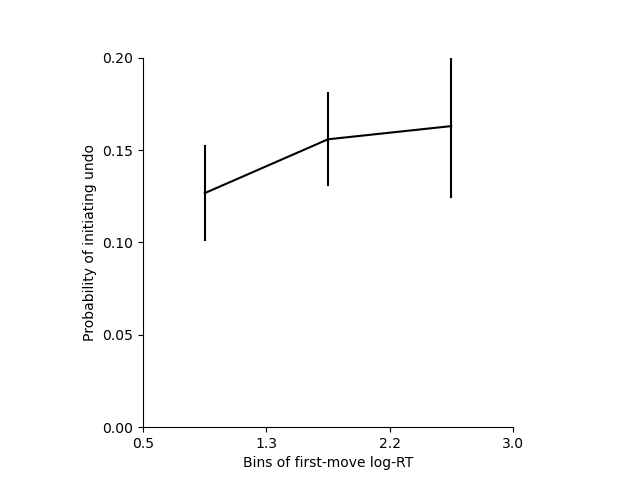

In [183]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.rt1_bin<=3],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
#axs.set_xticks(np.arange(0.5, 7.5, 1))
# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
axs.set_ylim([0,0.2])
axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='Bins of first-move log-RT', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_first_rt.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_log + (1 |subjects) + (1 |puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_log + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  1080.1   1102.2   -536.1   1072.1     1842 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7849 -0.2659 -0.1166 -0.0472  6.9214 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.401    2.898   
 puzzleID (Intercept) 2.011    1.418   
Number of obs: 1846, groups:  subjects, 99; puzzleID, 45

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.5888     0.5844  -7.853 4.07e-15 ***
RT1_log       0.4237     0.2155   1.967   0.0492 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
RT1_log -0.598


In [21]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_basic_log + (1 |subjects) + (1 |puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_basic_log + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  1083.3   1105.4   -537.7   1075.3     1842 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3203 -0.2645 -0.1171 -0.0473  6.5258 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.461    2.909   
 puzzleID (Intercept) 2.057    1.434   
Number of obs: 1846, groups:  subjects, 99; puzzleID, 45

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -4.1847     0.5728  -7.305 2.77e-13 ***
RT1_basic_log   0.1570     0.1968   0.798    0.425    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
RT1_basc_lg -0.570


#### correlation with undoRT

In [16]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['undoRT'].mean()))

SpearmanrResult(correlation=0.2908425359131318, pvalue=0.026767333235737715)


In [22]:
print(spearmanr(state_notundo_1undo.groupby(['subjects'])['RT1'].mean() , state_notundo_1undo.groupby(['subjects'])['submitRT'].mean()))

SpearmanrResult(correlation=0.5315247624896146, pvalue=3.5447747051316746e-08)


# Undo completion

## Error before and after undo

In [27]:
mas_gain_df = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','cum_error_end','error_beginning','error_rate_beginning','error_rate_end','mas_gain'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
        # all last undo
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            # get cumulative error at undo beginning
            cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
            cum_error_beginning_list.append(cum_error_beginning)
            error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
            error_beginning_list.append(error_beginning)
            error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
            error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        error_rate_end = list(df_undoTarget['error_rate'])
        # use each value in cum_error_beginning_list to subtract accu_severity_error
        mas_gain = []
        cum_error_end_list = []
        error_rate_end_list = []
        for i in range(len(cum_error_beginning_list)):
            mas_gain.append(cum_error_beginning_list[i] - accu_severity_error[i])
            cum_error_end_list.append(accu_severity_error[i])
            error_rate_end_list.append(error_rate_end[i])
        
        
        # if category is not empty, add it to an empty dataframe
        if len(mas_gain) > 0:
            mas_gain_df = pd.concat([mas_gain_df,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                               'cum_error_beginning':cum_error_beginning_list, 'cum_error_end':cum_error_end_list,
                                                               'error_beginning':error_beginning_list, 
                                                               'error_rate_beginning':error_rate_beginning_list,
                                                               'error_rate_end':error_rate_end_list,
                                                               'mas_gain':mas_gain})])


### Scatter plot

In [14]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])['cum_error_beginning','cum_error_end'].mean().reset_index()

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_34847/948503816.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['cum_error_beginning','cum_error_end'].mean().reset_index()


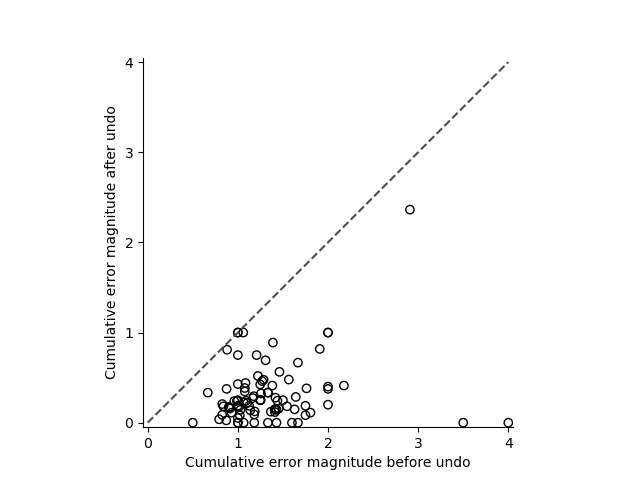

In [15]:
%matplotlib widget
fig1, ax1 = plt.subplots()

sns.scatterplot(x='cum_error_beginning', y='cum_error_end', 
                            # use white fill
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                data=error_df_sub) 
# add diagonal line
ax1.plot([0, 4], [0, 4], ls="--", c=".3")
ax1.set_xlim([-0.05,4.05])
ax1.set_ylim([-0.05,4.05])
ax1.set_xticks(np.arange(0, 4.5, 1))
ax1.set_yticks(np.arange(0, 4.5, 1))
ax1.set_xlabel("Cumulative error magnitude before undo")
ax1.set_ylabel("Cumulative error magnitude after undo")
ax1.set_aspect(1/ax1.get_data_ratio())
fig1.savefig(out_dir+'error_before_after_undo.png', dpi=300, bbox_inches='tight')
plt.show()

0.5286900147100068
0.34279494095060203


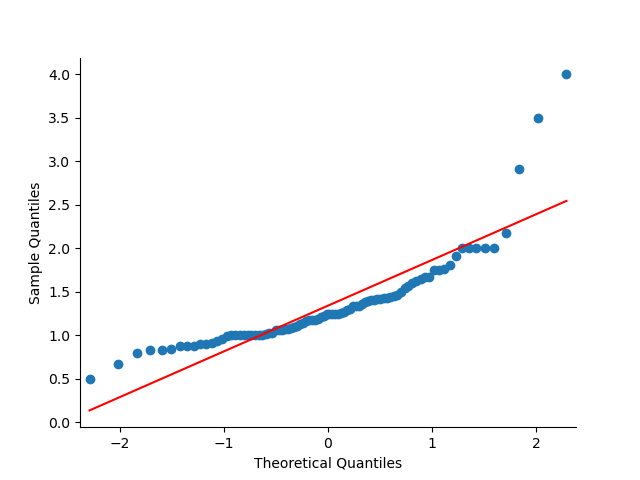

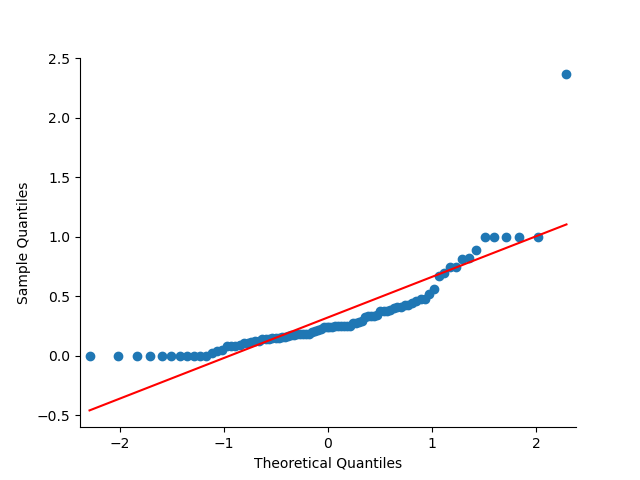

1.8266971276429214e-16


In [18]:
cum_error_before = mas_gain_df.groupby(['subjects'])['cum_error_beginning'].mean()
cum_error_after = mas_gain_df.groupby(['subjects'])['cum_error_end'].mean()

# check equal variance ----
print(np.std(cum_error_before, ddof=1))
print(np.std(cum_error_after, ddof=1))

# check normality ----
sm.qqplot(cum_error_before, line='s')
py.show()
sm.qqplot(cum_error_after, line='s')
py.show()

stat1, p1 = wilcoxon(cum_error_before, cum_error_after, alternative = 'greater')
print(p1)

### Error rate

In [28]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_df_sub

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3460544585.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


,subjects,error_rate_beginning,error_rate_end
0,0,0.171176,0.015152
1,1,0.252847,0.113872
2,2,0.299482,0.055556
3,3,0.547619,0.000000
4,4,0.266478,0.084921
...,...,...,...
85,94,0.800000,0.000000
86,95,0.144901,0.091991
87,96,0.120201,0.011792
88,97,0.436508,0.166667


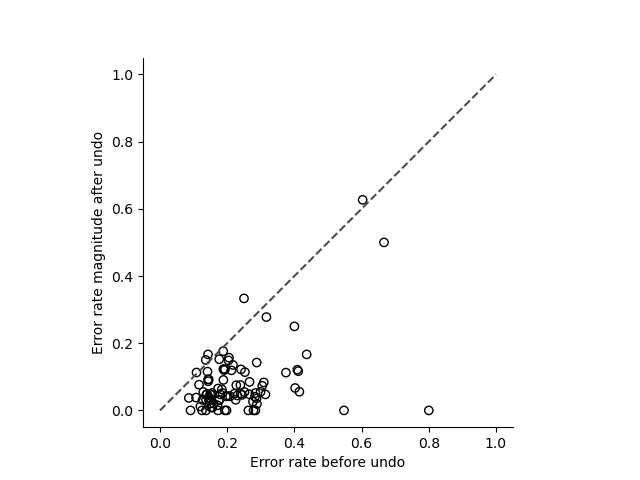

In [29]:
%matplotlib widget
fig1, ax1 = plt.subplots()

sns.scatterplot(x='error_rate_beginning', y='error_rate_end', 
                            # use white fill
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                data=error_df_sub) 
# add diagonal line
ax1.plot([0, 1], [0, 1], ls="--", c=".3")
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
# ax1.set_xticks(np.arange(0, 1.5, 1))
# ax1.set_yticks(np.arange(0, 1.5, 1))
ax1.set_xlabel("Error rate before undo")
ax1.set_ylabel("Error rate magnitude after undo")
ax1.set_aspect(1/ax1.get_data_ratio())
fig1.savefig(out_dir+'errorrate_before_after_undo.png', dpi=300, bbox_inches='tight')
plt.show()

## Proportion of different undo result

In [36]:
accu_error_3 = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        # last undo index when it is not the start city
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_nostart:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1

            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0: # the state before first undo
                lastUndo_idx_nostart = lastUndo_idx_nostart.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])

        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error) # the number of undo terminal
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1
            elif accu_severity_error[i] > 0: # undo too little
                category[i] = 2
        
        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_3 = pd.concat([accu_error_3,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list,
                                                                 'category':category})])

accu_error_3["terminal"] = "notstart"

In [37]:
# create empty dataframe
accu_error_2 = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level.loc[(sc_data_choice_level['subjects']==sub),:].sort_values(["puzzleID","index_copy"])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []

        dat_sbj_pzi = dat_sbj.loc[(dat_sbj['puzzleID'] == pzi),:].reset_index()    

        # last undo index when it is not the start city
        # only select rows when (dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi.lastUndo==1)&(dat_sbj_pzi.choice==0)].index
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_start:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            
            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0:
                lastUndo_idx_start = lastUndo_idx_start.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_start,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_start-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1

        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_2 = pd.concat([accu_error_2,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list,
                                                                 'category':category})])

accu_error_2["terminal"] = "start"

In [38]:
# combine accu_error_2 and accu_error_3 into one dataframe
accu_error = pd.concat([accu_error_2,accu_error_3])
# calcualte the proportion of each category plus terminal, grouped by subjects
accu_error_p = accu_error.groupby(['category','terminal','subjects']).size().unstack(fill_value=0).apply(lambda x: x/x.sum())
accu_error_p = accu_error_p.T

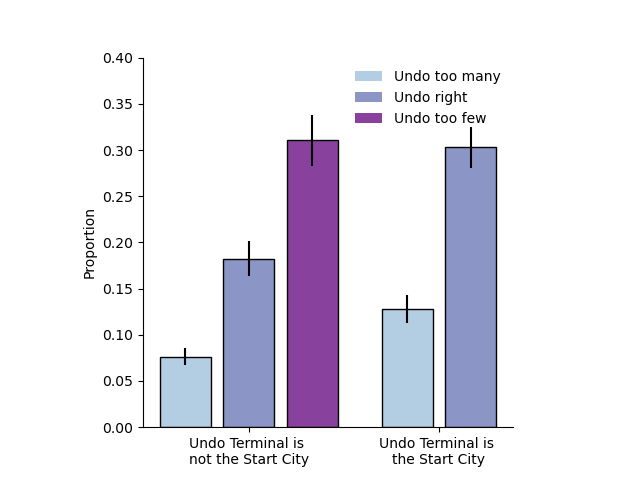

In [14]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
plt.bar(range(3), np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis=0),
        color= ["#b3cde3", "#8c96c6", "#88419d"], 
        edgecolor = 'k', 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"].shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis=0),
        edgecolor = 'k', 
        color= ["#b3cde3", "#8c96c6"],
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"].shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [Patch(facecolor='#b3cde3', label='Undo too many'),    
                   Patch(facecolor='#8c96c6', label='Undo right'),    
                   Patch(facecolor='#88419d', label='Undo too few')]
# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo Terminal is \nnot the Start City','Undo Terminal is \nthe Start City'])
plt.ylabel('Proportion')
# 
axs.set_ylim([0,0.4])
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_completion type.png', dpi=300, bbox_inches='tight')

## what predicts the undo terminal

### cumulative error magnitude

In [45]:
accu_error['undo_right'] = (accu_error.category==1)
accu_error['undo_too_many'] = (accu_error.category==0)
accu_error['undo_too_few'] = (accu_error.category==2)

,subjects,puzzleID,cum_error_beginning,error_beginning,error_rate_beginning,category,terminal,undo_right,undo_too_many,undo_too_few
0,0,28,3,0,0.500000,0,start,False,True,False
0,1,15,3,1,0.500000,1,start,True,False,False
0,1,18,2,0,0.250000,1,start,True,False,False
0,1,30,1,0,0.166667,1,start,True,False,False
0,1,38,2,1,0.666667,1,start,True,False,False
...,...,...,...,...,...,...,...,...,...,...
1,99,17,1,0,0.142857,0,notstart,False,True,False
0,99,24,1,0,0.333333,2,notstart,False,False,True
0,99,29,1,0,0.125000,0,notstart,False,True,False
0,99,31,1,0,0.111111,0,notstart,False,True,False


In [16]:
undo_right_sub = accu_error.groupby(['subjects','cum_error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['cum_error_beginning'])['undo_right'].count()

cum_error_beginning
1    82
2    82
3    58
4    31
5     4
6     1
Name: undo_right, dtype: int64

In [22]:
accu_error

,subjects,puzzleID,cum_error_beginning,error_beginning,category,terminal,undo_right,undo_too_many,undo_too_few
0,0,28,3,0,0,start,False,True,False
0,1,15,3,1,1,start,True,False,False
0,1,18,2,0,1,start,True,False,False
0,1,30,1,0,1,start,True,False,False
0,1,38,2,1,1,start,True,False,False
...,...,...,...,...,...,...,...,...,...
1,99,17,1,0,0,notstart,False,True,False
0,99,24,1,0,2,notstart,False,False,True
0,99,29,1,0,0,notstart,False,True,False
0,99,31,1,0,0,notstart,False,True,False


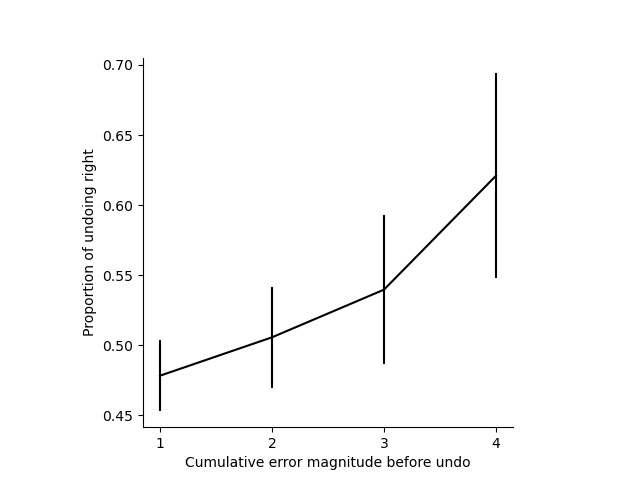

In [19]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='cum_error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.cum_error_beginning<=4],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_error.png', dpi=300, bbox_inches='tight')

In [24]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])

model_undo_right = lme4::glmer(undo_right ~  1 + cum_error_beginning + (1 |subjects) ,
                                  data = accu_error[accu_error$cum_error_beginning<=4,], family = binomial(link="logit"))

save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_cumulative_error.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + cum_error_beginning + (1 | subjects)
   Data: accu_error[accu_error$cum_error_beginning <= 4, ]

     AIC      BIC   logLik deviance df.resid 
  2761.6   2778.4  -1377.8   2755.6     2036 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6141 -0.9195 -0.5788  1.0049  2.0171 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2777   0.527   
Number of obs: 2039, groups:  subjects, 90

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.52904    0.12480  -4.239 2.25e-05 ***
cum_error_beginning  0.26863    0.06202   4.332 1.48e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cm_rrr_bgnn -0.771


### error magnitude before undo

In [25]:
undo_right_sub = accu_error.groupby(['subjects','error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_beginning'])['undo_right'].count()

error_beginning
0    86
1    76
2    33
3    14
4     1
6     1
Name: undo_right, dtype: int64

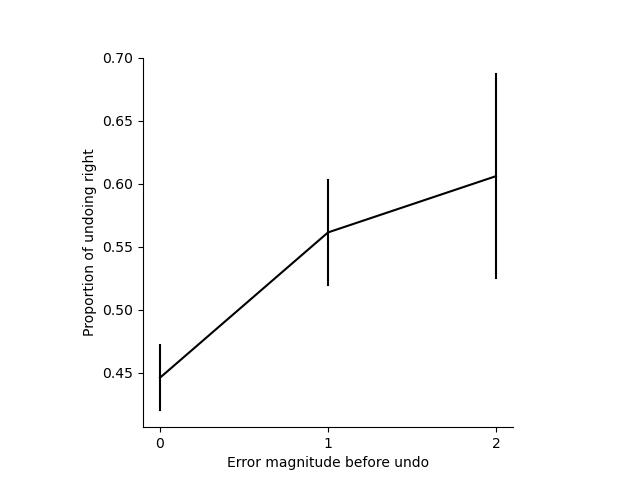

In [26]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.error_beginning<=2],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([0,1,2])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_error.png', dpi=300, bbox_inches='tight')

In [29]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])
accu_error$error_beginning <- scale(accu_error$error_beginning)
accu_error$cum_error_beginning <- scale(accu_error$cum_error_beginning)

model_undo_right = lme4::glmer(undo_right ~  1 + error_beginning + cum_error_beginning + (1 |subjects) ,
                                  data = accu_error[(accu_error$error_beginning<=2)&(accu_error$cum_error_beginning<=4),], 
                                  family = binomial(link="logit"))

save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_error_and_cumulative.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + error_beginning + cum_error_beginning + (1 |  
    subjects)
   Data: 
accu_error[(accu_error$error_beginning <= 2) & (accu_error$cum_error_beginning <=  
    4), ]

     AIC      BIC   logLik deviance df.resid 
  2664.8   2687.1  -1328.4   2656.8     1974 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8423 -0.8874 -0.5206  1.0139  1.9904 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2944   0.5426  
Number of obs: 1978, groups:  subjects, 90

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.10880    0.08209  -1.325  0.18507    
error_beginning      0.23900    0.07338   3.257  0.00112 ** 
cum_error_beginning  0.21226    0.05271   4.027 5.66e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Ef

### Error rate

In [41]:
undo_right_sub = accu_error.groupby(['subjects','error_rate_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_rate_beginning'])['undo_right'].count()

error_rate_beginning
0.090909    28
0.100000    28
0.111111    66
0.125000    70
0.142857    60
0.166667    54
0.200000    24
0.222222    16
0.250000    69
0.285714    62
0.333333    48
0.375000     6
0.400000    29
0.428571    35
0.500000    57
0.571429     1
0.600000    20
0.666667    19
0.714286     1
0.750000     7
0.800000    14
0.833333     1
1.000000    22
1.250000     1
1.333333     7
1.500000     6
2.000000     1
3.000000     1
Name: undo_right, dtype: int64

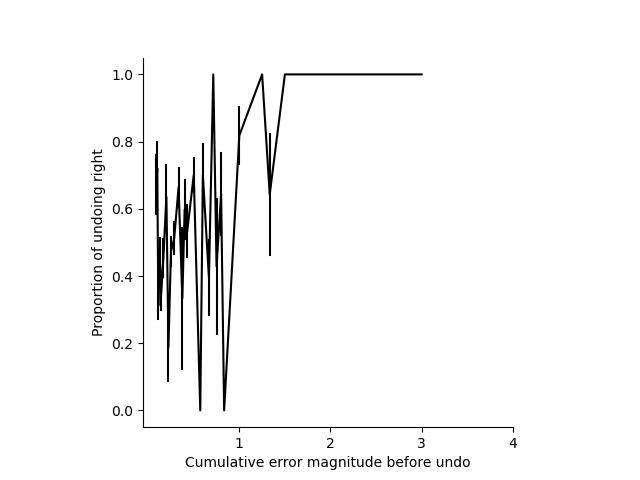

In [43]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_rate_beginning', y='undo_right',
                data = undo_right_sub,
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_errorrate.png', dpi=300, bbox_inches='tight')

## Correlations

## Metric 1: proportions

In [46]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_right_prop = accu_error.groupby(['subjects'])['undo_right'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_right_prop.index)]

spearmanr(score, undo_right_prop)

SpearmanrResult(correlation=-0.13312064506005297, pvalue=0.21100181575591548)

In [48]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_few_prop = accu_error.groupby(['subjects'])['undo_too_few'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_few_prop.index)]

spearmanr(score, undo_few_prop)

SpearmanrResult(correlation=0.1470036625195117, pvalue=0.16677864009093307)

In [64]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_right_prop.index)]
spearmanr(balanced_accuracy, undo_right_prop)

SpearmanrResult(correlation=-0.033595457200651664, pvalue=0.7532566675233603)

In [65]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_few_prop.index)]
spearmanr(balanced_accuracy, undo_few_prop)

SpearmanrResult(correlation=-0.06698676011526265, pvalue=0.5304532980708084)

## Metric 2: Error rate change

In [68]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, score)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3807902533.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.03115437580352458, pvalue=0.7706722334841731)

In [70]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, balanced_accuracy)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/2976432119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.0444307239747956, pvalue=0.6775415110542389)

## Metric 3: MAS gain

In [75]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(mas_gain.index)]
spearmanr(mas_gain, balanced_accuracy)

SpearmanrResult(correlation=-0.10919093542725634, pvalue=0.30561654498857593)

In [79]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(mas_gain.index)]
spearmanr(mas_gain, score)

SpearmanrResult(correlation=0.25321224856022057, pvalue=0.016040797773219848)